In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import pandas as pd
import warnings
from utils import *
warnings.filterwarnings("ignore")

# plot setting
sns.set_context('paper')
sns.set(style = "ticks")
cmap_point = sns.color_palette('muted', as_cmap=True)
# cmap_point = sns.color_palette('muted')
cmap_DB = sns.color_palette('pastel', as_cmap=True)

# random state
np.random.seed(427)
randomseeds = np.random.randint(1992427,size=5)

## Problem 2: Larger unlabeled subset (Written Report)
- Now we will work with the larger, unlabeled subset in p2_unsupervised. This dataset is has not been processed, so you should process using the same log transform as in Problem 1.

### Part 1: Visualization
- Cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells.
    - 3 main groups
- Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions
    - there are subgroups under main groups

In [2]:
X = np.load('./data/p2_unsupervised/X.npy')
X = np.log2(X+1)

In [3]:
np.trace(X)

1141.7662275009184

#### Part 1.1
Provide at least one visualization which clearly shows the existence of the three main brain cell types described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from a different group (for example, excitatory vs inhibitory) can differ greatly.

##### Part 1.1.1 Find best clustering result with given k-clusters
1. K-means
2. Gaussian Mixture Model
3. given k-clusters Hierarchical clustering
4. Spectral clustering

- Before finding the clustering label, for algorithms using Euclidean distances(etc.) to compute the dissimilarity between samples, we need to do dimensionality reduction to alleviate the "curse of dimensionality".
- Clustering algorithms using Euclidean distances include
    - K-means
    - Hierarchical clustering
    - Spectral clustering
        - performs a low-dimension embedding of the affinity matrix between samples
        - custering alg like MDS

In [52]:
# determine the number of components to use for 
pca = PCA()
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(2169, 2169)


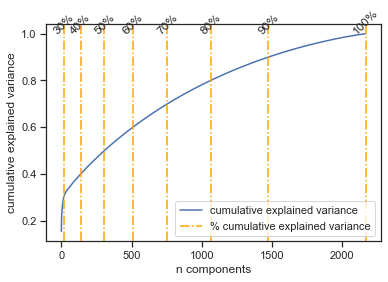

First 509 components have been chosen for further analysis (60% of cumulate explained variance)
Top 2 PC explained 19.92509945219414% of total variance


In [5]:
## at least n% cumulative explained variance ratio
variance_ratio = pca.explained_variance_ratio_
cumulate_ratio = np.cumsum(variance_ratio)
al90 = np.min(np.where(cumulate_ratio>=0.9))
al80 = np.min(np.where(cumulate_ratio>=0.8))
al70 = np.min(np.where(cumulate_ratio>=0.7))
al60 = np.min(np.where(cumulate_ratio>=0.6))
al50 = np.min(np.where(cumulate_ratio>=0.5))
al40 = np.min(np.where(cumulate_ratio>=0.4))
al30 = np.min(np.where(cumulate_ratio>=0.3))
al20 = np.min(np.where(cumulate_ratio>=0.2))
alps = [2169, al90, al80, al70, al60, al50, al40, al30]
## cumulation plot
sns.lineplot(x=range(len(variance_ratio)), y=cumulate_ratio)
for i in range(len(alps)):
    plt.axvline(x=alps[i], color='orange', linestyle='-.')
    plt.text(x=alps[i], y=1, s=f'{100-i*10}%', ha='center', rotation=45)
plt.legend(['cumulative explained variance' ,'% cumulative explained variance'])
plt.ylabel('cumulative explained variance')
plt.xlabel('n components')
plt.savefig('cumulative explained variance.png')
plt.show()
print(f'First {alps[4]} components have been chosen for further analysis (60% of cumulate explained variance)')
print(f'Top 2 PC explained {cumulate_ratio[1]*100}% of total variance')

# !!! sklearn PCA method: assign svd_solver ='full', it's a big difference between 'auto' and 'full'

In [43]:
X_pca.shape, X.shape

((2169, 2169), (2169, 45768))

In [53]:
# project dataset onto first 509 components
pca60p = PCA(n_components = al60)
X_pca_60p = pca60p.fit_transform(X)
print(X_pca_60p.shape)

(2169, 509)


In [54]:
# auto
np.sum(pca.explained_variance_ratio_[al30:al60]), np.sum(pca60p.explained_variance_ratio_[al30:])

(0.30166922319604594, 0.2927224460764332)

In [47]:
# full
np.sum(pca.explained_variance_ratio_[al30:al60]), np.sum(pca60p.explained_variance_ratio_[al30:])

(0.30166922319604594, 0.30166922319604594)

In [48]:
pca.explained_variance_ratio_[al30:al60].shape, pca60p.explained_variance_ratio_[al30:].shape

((492,), (492,))

In [56]:
slide_all = X_pca[:,al30:al60]
slide_init60 = X_pca_60p[:,al30:]

print(slide_all.shape, slide_init60.shape)

(2169, 492) (2169, 492)


In [57]:
for m in ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']:
    print(f'metric={m}')
    compare_m = pairwise_distances(slide_init60.T, slide.T, metric=m)
    itslef_all = pairwise_distances(slide.T, slide.T, metric=m)
    itself_60 = pairwise_distances(slide_init60.T, slide_init60.T, metric=m)
    print(f'compare shape={compare_m.shape}, itself shape={itslef_all.shape},{itself_60.shape}')
    print(f'compare trace= {np.trace(compare_m)}')
    print(f'itself trace= {np.trace(itslef_all)}, {np.trace(itself_60)}')
    print('---')

metric=cityblock
compare shape=(492, 492), itself shape=(492, 492),(492, 492)
compare trace= 5744293.209882168
itself trace= 0.0, 0.0
---
metric=cosine
compare shape=(492, 492), itself shape=(492, 492),(492, 492)
compare trace= 411.2235752061009
itself trace= 1.1357581541915351e-13, 2.4513724383723456e-13
---
metric=euclidean
compare shape=(492, 492), itself shape=(492, 492),(492, 492)
compare trace= 171677.5872933068
itself trace= 0.0019487639355099508, 0.0029474450499719163
---
metric=l1
compare shape=(492, 492), itself shape=(492, 492),(492, 492)
compare trace= 5744293.209882168
itself trace= 0.0, 0.0
---
metric=l2
compare shape=(492, 492), itself shape=(492, 492),(492, 492)
compare trace= 171677.5872933068
itself trace= 0.0019487639355099508, 0.0029474450499719163
---
metric=manhattan
compare shape=(492, 492), itself shape=(492, 492),(492, 492)
compare trace= 5744293.209882168
itself trace= 0.0, 0.0
---


In [26]:
pairwise_distances(slide.T).shape

(492, 492)

In [25]:
np.trace(pairwise_distances(slide.T))

0.0

In [7]:
# # form 2-d MDS plot 0,3
# # for rs in randomseeds:
# #     mds = MDS(n_components=2, random_state=rs)
# #     X_mds = mds.fit_transform(X_pca_60p)
# #     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
# #     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=kmeans_label, ax=ax2, palette=cmap_point[:3])
# #     f.suptitle(f'rs={rs}')
# #     plt.show()
# ## mds.stress_ = the loss function of MDS
# ### (0.5*np.sum((mds.dissimilarity_matrix_ - pairwise_distances(X_mds))**2))
# mds = MDS(n_components=2, random_state=randomseeds[3])
# X_mds = mds.fit_transform(X_pca_60p)

In [8]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
# sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], ax=ax1, palette=cmap_point[:3])
# sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], ax=ax2, palette=cmap_point[:3])
# f.suptitle(f'rs = {randomseeds[0]}')
# plt.show()

In [9]:
# number of main groups
k = 3

In [10]:
# K-means
# kmeans_labels = []
# for rs in randomseeds:
#     kmeans = KMeans(n_clusters=k, random_state=rs).fit(X_pca_60p)
#     kmeans_label = kmeans.labels_
#     kmeans_labels.append(kmeans_label)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=kmeans_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=kmeans_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'rs={rs}')
#     plt.show()
print(f'rs = {randomseeds[0]} has been chosen for consistency')
ds = X_pca_60p
kmeans = KMeans(n_clusters=k, random_state=randomseeds[0]).fit(ds)
kmeans_label = kmeans.labels_

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
# sns.scatterplot(x=ds[:,0], y=ds[:,1], hue=kmeans_label, ax=ax1, palette=cmap_point[:3])
# sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=kmeans_label, ax=ax2, palette=cmap_point[:3])
# f.suptitle(f'rs={randomseeds[0]}')
# plt.show()

rs = 1922338 has been chosen for consistency


In [11]:
# Hierarchical clustering
linkages = ['ward', 'complete', 'average', 'single']
# HC_labels = []
# for link in linkages:
#     HC = AgglomerativeClustering(n_clusters=k, linkage=link).fit(X_pca_60p)
#     HC_label = HC.labels_
#     HC_labels.append(HC_label)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=HC_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=HC_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'linkage={link}')
#     plt.show()
print(f'linkage = {linkages[0]} has been chosen for best performance')

HC = AgglomerativeClustering(n_clusters=3, linkage=linkages[0], compute_distances=True, compute_full_tree=True).fit(X_pca_60p)
HC_label = HC.labels_


# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
# sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=HC_label, ax=ax1, palette=cmap_point[:3])
# sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=HC_label, ax=ax2, palette=cmap_point[:3])
# f.suptitle(f'linkage= {linkages[0]}')
# plt.show()

linkage = ward has been chosen for best performance


In [12]:
# Gaussian Mixture Model

cov_types = ['spherical', 'tied', 'diag', 'full']
# GMM_labels = []
# for cov_type in cov_types:
#     GMM = GaussianMixture(n_components=k, covariance_type=cov_type).fit(X_pca_60p)
#     GMM_label = GMM.predict(X_pca_60p)
#     GMM_labels.append(GMM_label)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=GMM_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=GMM_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'covariance_type={cov_type}')
#     plt.show()
print(f'covariance_type = {cov_types[-1]} has been chosen for best performance, similar to K-means')


# GMM = GaussianMixture(n_components=k, covariance_type=cov_types[-1]).fit(X_pca_60p)
# GMM_label = GMM.predict(X_pca_60p)


# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
# sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=GMM_label, ax=ax1, palette=cmap_point[:3])
# sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=GMM_label, ax=ax2, palette=cmap_point[:3])
# f.suptitle(f'covariance_type= {cov_types[-1]}')
# plt.show()

covariance_type = full has been chosen for best performance, similar to K-means


In [13]:
# Spectral clustering
affinities = ['nearest_neighbors', 'rbf']
affinities_precomputed = ['precomputed', 'precomputed_nearest_neighbors']
SC_labels = []
# for aff in affinities:
#     SC = SpectralClustering(n_clusters=k, random_state=randomseeds[0], affinity=aff).fit(X_pca_60p)
#     SC_label = SC.labels_
#     SC_labels.append(SC_label)
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=SC_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=SC_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'affinity={aff}')
#     plt.show()


# for affpre in affinities_precomputed:
#     SC = SpectralClustering(n_clusters=k, random_state=randomseeds[0], affinity=aff).fit(pairwise_distances(X_pca_60p))
#     SC_label = SC.labels_
#     SC_labels.append(SC_label)
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=SC_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=SC_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'affinity={affpre}')
#     plt.show()   
print(f'Spectral clustering is not suitable')

Spectral clustering is not suitable


##### Part 1.1.2 Add Decision boundaries on 2-d plot

In [14]:
X_pca2 = X_pca_60p[:,:2]
y= count_sort_pseudo_label(HC_label)

# PCA2 boundaries
clf = SVC(random_state=0, C=0.4, break_ties=True, probability=True)
cv_results = cross_validate(clf, X_pca2, y, return_estimator=True)
print('cv test score = ', cv_results['test_score'])

clf_3class_pca2 = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_3class_pca2.score(X_pca2, y))
print('---')
# np.where(clf_3class_pca2.predict(X_pca2)!=y), clf_3class_pca2.get_params()

cv test score =  [0.99078341 1.         1.         1.         0.99769053]
train acc =
 0.9995389580451821
---


In [17]:
# mds boundaries 0,1.4。3,11

clf = SVC(random_state=0, C=10.6, break_ties=True, probability=True)
cv_results = cross_validate(clf, X_mds, y, return_estimator=True)
print('cv test score = ', cv_results['test_score'])

clf_3class_mds = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_3class_mds.score(X_mds, y))
print('---')
# np.where(clf_3class_mds.predict(X_mds)!=y), clf_3class_mds.get_params()

NameError: name 'X_mds' is not defined

NameError: name 'X_mds' is not defined

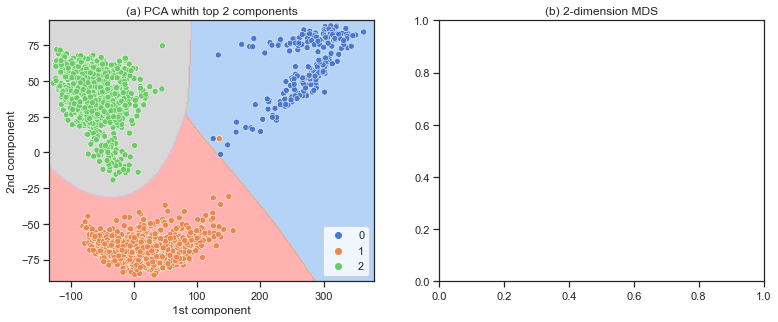

In [18]:
# output fig
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))


# plot PCA
ax1.set_title('(a) PCA whith top 2 components')
x1x1_pca2, x2x2_pca2 = make_meshgrid(X_pca2[:,0], X_pca2[:,1])
plot_contours(ax1, clf_3class_pca2, x1x1_pca2, x2x2_pca2, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y, ax=ax1, palette=cmap_point[:3])
ax1.set_xlabel('1st component')
ax1.set_ylabel('2nd component')

# plot MDS
ax2.set_title('(b) 2-dimension MDS')
x1x1_mds, x2x2_mds = make_meshgrid(X_mds[:,0], X_mds[:,1])
plot_contours(ax2, clf_3class_mds, x1x1_mds, x2x2_mds, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=y, ax=ax2, palette=cmap_point[:3])
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
# export fig
f.savefig('p2-part1-1.png') 
plt.show()

In [19]:
(1/0.4)/(1/10.6)

26.499999999999996

#### Part 1.2
Provide at least one visualization which supports the claim that within each of the three types, there are numerous possible sub-types for a cell. In your visualization, highlight which of the three main types these sub-types belong to. Again, explain how your visualization supports the claim.

In [20]:
print(f'count sampls in main groups, 0={np.sum(y==0)}, 1={np.sum(y==1)}, 2={np.sum(y==2)}')
number_of_main_group = len(np.unique(y))
number_of_main_group

count sampls in main groups, 0=218, 1=860, 2=1091


3

In [21]:
# sbugroup cmap
## from dark to pastel
def cmap_sbb_0(ncolors, as_cmap=False):
    start = sns.color_palette("bright",as_cmap=True)[0]
    end = sns.color_palette("bright",as_cmap=True)[0+6]
    return sns.color_palette(palette=f'blend:{start},{end}',n_colors=ncolors, as_cmap=as_cmap)
def cmap_sbb_1(ncolors, as_cmap=False):
    return sns.color_palette(palette=f'husl',n_colors=ncolors, as_cmap=as_cmap)
def cmap_sbb_2(ncolors, as_cmap=False):
    start = sns.color_palette("bright",as_cmap=True)[2]
    end = sns.color_palette("bright",as_cmap=True)[2+6]
    return sns.color_palette(palette=f'blend:{start},{end}',n_colors=ncolors, as_cmap=as_cmap)

### 1. kmeens

#### find unlabeled 2-d sub group presentation

In [22]:
al35 = np.where(cumulate_ratio>=0.35)[0][0]
al325 = np.where(cumulate_ratio>=0.325)[0][0]
al375 = np.where(cumulate_ratio>=0.375)[0][0]
al425 = np.where(cumulate_ratio>=0.425)[0][0]
al45 = np.where(cumulate_ratio>=0.45)[0][0]
al475 = np.where(cumulate_ratio>=0.475)[0][0]
n_comps = [al30, al325, al35]#, al375, al40, al425, al45, al475, al50]
n_comps

[17, 35, 66]

In [23]:
# X pc 30%, 32.5%, 35%
X_pca_30_35 = []
for n in range(len(n_comps)):
    pcahc = PCA(n_components = n_comps[n])
    X_pca = pcahc.fit_transform(X)
    X_pca_30_35.append(X_pca)

In [24]:
# t-SNE for each pcs
perplexities = np.arange(5,70,10)
X_TSNEs = np.zeros((len(n_comps), perplexities.shape[0])).tolist()
X_TSNEs

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [25]:
# for n in range(3):
#     X_pca = X_pca_30_35[n]
#     for p in range(perplexities.shape[0]):
#         tsne = TSNE(n_components=2, random_state=randomseeds[0],
#                     perplexity=perplexities[p])
#         X_tsne = tsne.fit_transform(X_pca)
#         X_tsne_0 = tsne.fit_transform(X_pca[y==0])
#         X_tsne_1 = tsne.fit_transform(X_pca[y==1])
#         X_tsne_2 = tsne.fit_transform(X_pca[y==2])

#         X_TSNEs[n][p] = [X_tsne, X_tsne_0, X_tsne_1, X_tsne_2]

#### find k-cluster by elbow and avg silhouette_score

In [28]:
# find number of cluster by kmeans
find_range = range(2,22)
find_k_shape = (len(n_comps), number_of_main_group,len(find_range))

kmean_sublabels = np.zeros(find_k_shape).tolist()
WGSS_hist = np.zeros(find_k_shape)
silhouette_score_hist = np.zeros(find_k_shape)

for n in range(3):
    X_pca = X_pca_30_35[n]
    for k in find_range:
        kmeans_0 = KMeans(n_clusters=k, random_state=randomseeds[0]).fit(X_pca[y==0,:])
        kmeans_1 = KMeans(n_clusters=k, random_state=randomseeds[0]).fit(X_pca[y==1,:])
        kmeans_2 = KMeans(n_clusters=k, random_state=randomseeds[0]).fit(X_pca[y==2,:])

        kmean_sublabels[n][0][k-2] = kmeans_0.labels_
        kmean_sublabels[n][1][k-2] = kmeans_1.labels_
        kmean_sublabels[n][2][k-2] = kmeans_2.labels_

        WGSS_hist[n, 0, k-2] = kmeans_0.inertia_
        WGSS_hist[n, 1, k-2] = kmeans_1.inertia_
        WGSS_hist[n, 2, k-2] = kmeans_2.inertia_

        silhouette_score_hist[n, 0, k-2] = silhouette_score(X_pca[y==0,:], kmeans_0.labels_)
        silhouette_score_hist[n, 1, k-2] = silhouette_score(X_pca[y==1,:], kmeans_1.labels_)
        silhouette_score_hist[n, 2, k-2] = silhouette_score(X_pca[y==2,:], kmeans_2.labels_)

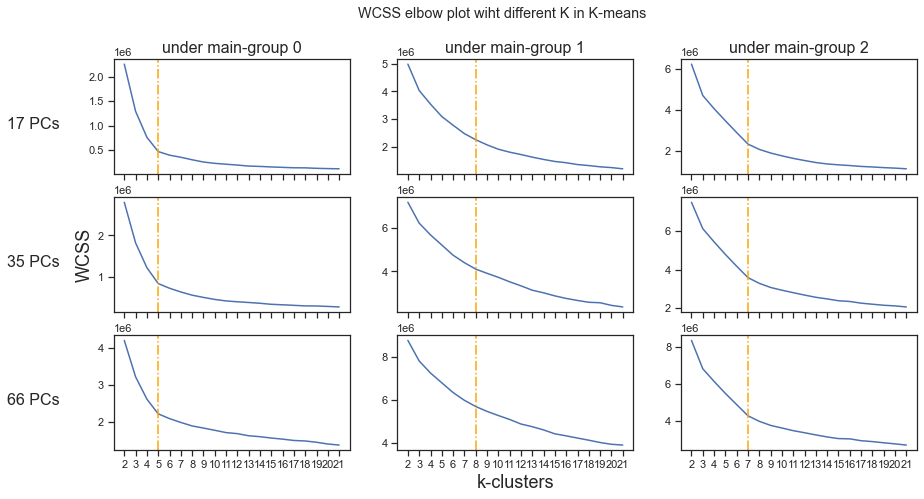

In [29]:
# elbow plot
# for n in range(3):
f, ax = plt.subplots(3, 3, figsize=(4.8*3,2.4*3), sharex=True)
for i in range(3):
    for j in range(3):
        sns.lineplot(x=find_range, y=WGSS_hist[i,j], ax=ax[i,j])

        if j ==0:
            ax[i,j].axvline(x=5, color='orange', linestyle='-.')
        elif j==1:
            ax[i,j].axvline(x=8, color='orange', linestyle='-.')
        elif j==2:
            ax[i,j].axvline(x=7, color='orange', linestyle='-.')
plt.xticks(find_range)
ax[0,1].set_xlabel('k-clusters', size=18)
ax[1,1].set_xlabel('k-clusters', size=18)
ax[2,1].set_xlabel('k-clusters', size=18)

ax[0,0].set_title(f'under main-group 0', size=16, loc='center')
ax[0,1].set_title(f'under main-group 1', size=16, loc='center')
ax[0,2].set_title(f'under main-group 2', size=16, loc='center')

ax[0,0].text(-0.45, 0.5, '17 PCs', transform=ax[0,0].transAxes, fontsize=16,
        verticalalignment='top')
ax[1,0].text(-0.45, 0.5, '35 PCs', transform=ax[1,0].transAxes, fontsize=16,
        verticalalignment='top')
ax[2,0].text(-0.45, 0.5, '66 PCs', transform=ax[2,0].transAxes, fontsize=16,
        verticalalignment='top')

ax[1,0].set_ylabel(f'WCSS', size=18)


f.suptitle(f'WCSS elbow plot wiht different K in K-means')
f.savefig('p2-part2-1_1.png') 
plt.show()

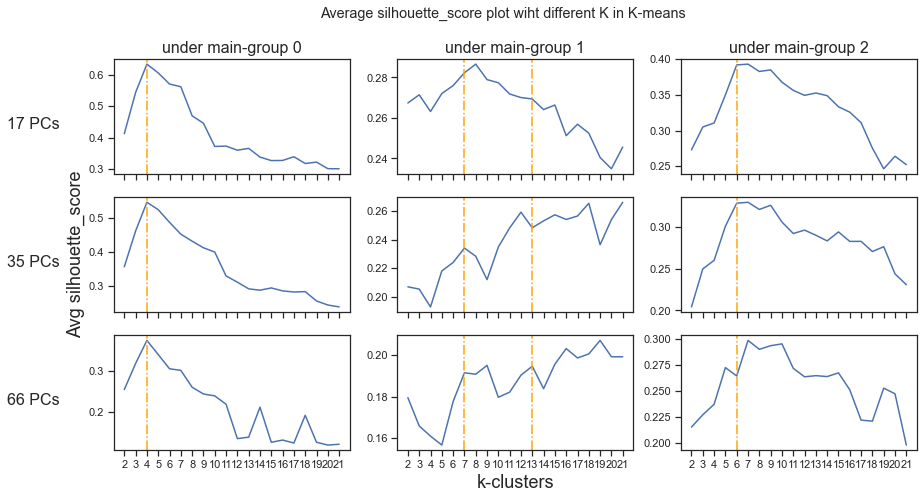

In [30]:
# avg silhouette_score plot
f, ax = plt.subplots(3, 3, figsize=(4.8*3,2.4*3), sharex=True)
for i in range(3):
    for j in range(3):
        sns.lineplot(x=find_range, y=silhouette_score_hist[i,j], ax=ax[i,j])
#         ax[i,j].tick_params(top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
        if j ==0:
            ax[i,j].axvline(x=4, color='orange', linestyle='-.')
        elif j==1:
            ax[i,j].axvline(x=7, color='orange', linestyle='-.')
            ax[i,j].axvline(x=13, color='orange', linestyle='-.')
        elif j==2:
            ax[i,j].axvline(x=6, color='orange', linestyle='-.')
plt.xticks(find_range)
ax[0,1].set_xlabel('k-clusters', size=18)
ax[1,1].set_xlabel('k-clusters', size=18)
ax[2,1].set_xlabel('k-clusters', size=18)

ax[0,0].set_title(f'under main-group 0', size=16, loc='center')
ax[0,1].set_title(f'under main-group 1', size=16, loc='center')
ax[0,2].set_title(f'under main-group 2', size=16, loc='center')

ax[0,0].text(-0.45, 0.5, '17 PCs', transform=ax[0,0].transAxes, fontsize=16,
        verticalalignment='top')
ax[1,0].text(-0.45, 0.5, '35 PCs', transform=ax[1,0].transAxes, fontsize=16,
        verticalalignment='top')
ax[2,0].text(-0.45, 0.5, '66 PCs', transform=ax[2,0].transAxes, fontsize=16,
        verticalalignment='top')


ax[1,0].set_ylabel(f'Avg silhouette_score', size=18)

f.suptitle(f'Average silhouette_score plot wiht different K in K-means')
f.savefig('p2-part2-1_2.png') 
plt.show()


# print(f'maximun 0={np.argmax(silhouette_score_hist[0])+2}, 1={np.argmax(silhouette_score_hist[1])+2}, 2={np.argmax(silhouette_score_hist[2])+2}')

In [31]:
# for n in range(3):
#     for p in range(perplexities.shape[0]):
        
#         scatterdata= X_TSNEs[n][p]
        
#         f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25.6,4.8))
#         sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=y, palette=cmap_point[:3], ax=ax1)

#         hue_0 = count_sort_pseudo_label(kmean_sublabels[n][0][2])
#         hue_1 = count_sort_pseudo_label(kmean_sublabels[n][1][5])
#         hue_2 = count_sort_pseudo_label(kmean_sublabels[n][2][4])
#         n_sub_groups_0 = len(np.unique(hue_0))
#         n_sub_groups_1 = len(np.unique(hue_1))
#         n_sub_groups_2 = len(np.unique(hue_2))
#         sns.scatterplot(x=scatterdata[1][:,0], y=scatterdata[1][:,1], hue=hue_0,
#                         palette=cmap_sbb_0(n_sub_groups_0), ax=ax2)

#         sns.scatterplot(x=scatterdata[2][:,0], y=scatterdata[2][:,1], hue=hue_1,
#                         palette=cmap_sbb_1(n_sub_groups_1), ax=ax3)

#         sns.scatterplot(x=scatterdata[3][:,0], y=scatterdata[3][:,1], hue=hue_2,
#                         palette=cmap_sbb_2(n_sub_groups_2), ax=ax4)

#         f.suptitle(f' n_comps={n_comps[n]}, perplexity={perplexities[p]}, sub0={4}, sub1={11}, sub2={6}')
#         plt.show()

In [32]:
# # for i in range(len(X_TSNEs)):
# for i in [4]:
    

#     sns.scatterplot(x=X_TSNEs[i][0][:,0], y=X_TSNEs[i][0][:,1], hue=y, palette=cmap_point[:3], ax=ax1)
    
    
#     hue_0 = count_sort_pseudo_label(kmean_sublabels[0][2])
#     hue_1 = count_sort_pseudo_label(kmean_sublabels[1][5])
#     hue_2 = count_sort_pseudo_label(kmean_sublabels[2][4])
    
#     n_sub_groups_0 = len(np.unique(hue_0))
#     n_sub_groups_1 = len(np.unique(hue_1))
#     n_sub_groups_2 = len(np.unique(hue_2))
#     sns.scatterplot(x=X_TSNEs[i][1][:,0], y=X_TSNEs[i][1][:,1], hue=hue_0,
#                     palette=cmap_sbb_0(n_sub_groups_0), ax=ax2)

#     sns.scatterplot(x=X_TSNEs[i][2][:,0], y=X_TSNEs[i][2][:,1], hue=hue_1,
#                     palette=cmap_sbb_1(n_sub_groups_1), ax=ax3)

#     sns.scatterplot(x=X_TSNEs[i][3][:,0], y=X_TSNEs[i][3][:,1], hue=hue_2,
#                     palette=cmap_sbb_2(n_sub_groups_2), ax=ax4)

#     f.suptitle(f' n_comps={66}, perplexity={55}, sub0={4}, sub1={7}, sub2={6}')
#     plt.show()

### AgglomerativeClustering

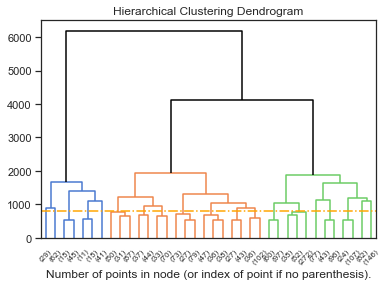

In [26]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
d = plot_dendrogram(HC, truncate_mode='lastp', p=36 ,leaf_rotation=45, labels=y, count_sort=True,
                color_threshold=3000, above_threshold_color='black', cmap=cmap_point)
# plt.axhline(y=1050, color='orange', linestyle='-.')
plt.axhline(y=800, color='orange', linestyle='-.')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [27]:
find_HC_shape = (len(n_comps), number_of_main_group)

HC_sublabels = np.zeros(find_HC_shape).tolist()
find_HC_shape

(3, 3)

In [28]:
for n in range(3):
    X_pca = X_pca_30_35[n]
    
    HC_0 = AgglomerativeClustering(n_clusters=4, linkage='ward', 
                                 compute_distances=True, compute_full_tree=True).fit(X_pca[y==0,:])
    HC_1 = AgglomerativeClustering(n_clusters=4, linkage='ward', 
                                 compute_distances=True, compute_full_tree=True).fit(X_pca[y==1,:])
    HC_2 = AgglomerativeClustering(n_clusters=6, linkage='ward', 
                                 compute_distances=True, compute_full_tree=True).fit(X_pca[y==2,:])
    
    HC_sublabels[n][0] = HC_0.labels_
    HC_sublabels[n][1] = HC_1.labels_
    HC_sublabels[n][2] = HC_2.labels_

In [29]:
# for n in range(3):
#     for p in range(perplexities.shape[0]):
        
#         scatterdata= X_TSNEs[n][p]
        
#         f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25.6,4.8))
#         sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=y, palette=cmap_point[:3], ax=ax1)

#         hue_0 = count_sort_pseudo_label(HC_sublabels[n][0])
#         hue_1 = HC_sublabels[n][1]
#         hue_2 = count_sort_pseudo_label(HC_sublabels[n][2])
#         n_sub_groups_0 = len(np.unique(hue_0))
#         n_sub_groups_1 = len(np.unique(hue_1))
#         n_sub_groups_2 = len(np.unique(hue_2))
#         sns.scatterplot(x=scatterdata[1][:,0], y=scatterdata[1][:,1], hue=hue_0,
#                         palette=cmap_sbb_0(n_sub_groups_0), ax=ax2)

#         sns.scatterplot(x=scatterdata[2][:,0], y=scatterdata[2][:,1], hue=hue_1,
#                         palette=cmap_sbb_1(n_sub_groups_1), ax=ax3)

#         sns.scatterplot(x=scatterdata[3][:,0], y=scatterdata[3][:,1], hue=hue_2,
#                         palette=cmap_sbb_2(n_sub_groups_2), ax=ax4)
#         ax3.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))
        
#         ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
#         ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
#         ax3.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
#         ax4.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
#         f.suptitle(f' n_comps={n_comps[n]}, perplexity={perplexities[p]}, sub0={4}, sub1={7}, sub2={6}')
#         plt.show()

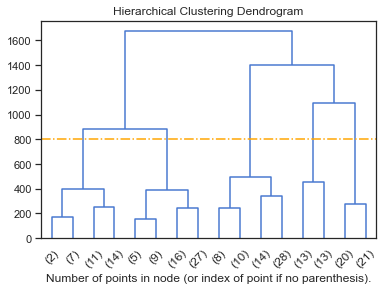

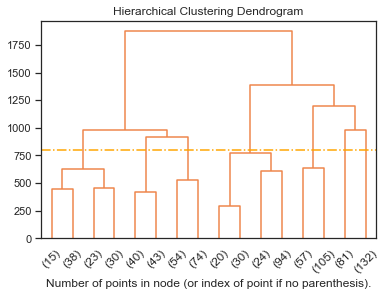

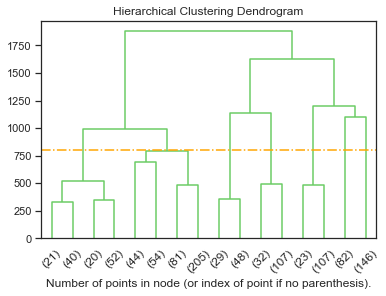

In [30]:

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
d = plot_dendrogram(HC_0, truncate_mode='level', p=3 ,leaf_rotation=45, count_sort=True,
                color_threshold=3000, above_threshold_color='black', cmap=[cmap_point[0]])
plt.axhline(y=800, color='orange', linestyle='-.')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
d = plot_dendrogram(HC_1, truncate_mode='level', p=3 ,leaf_rotation=45, count_sort=True,
                color_threshold=3000, above_threshold_color='black', cmap=[cmap_point[1]])
plt.axhline(y=800, color='orange', linestyle='-.')
# plt.axhline(y=500, color='orange', linestyle='-.')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
d = plot_dendrogram(HC_2, truncate_mode='level', p=3 ,leaf_rotation=45, count_sort=True,
                color_threshold=3000, above_threshold_color='black', cmap=[cmap_point[2]])
plt.axhline(y=800, color='orange', linestyle='-.')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

TypeError: 'float' object is not subscriptable

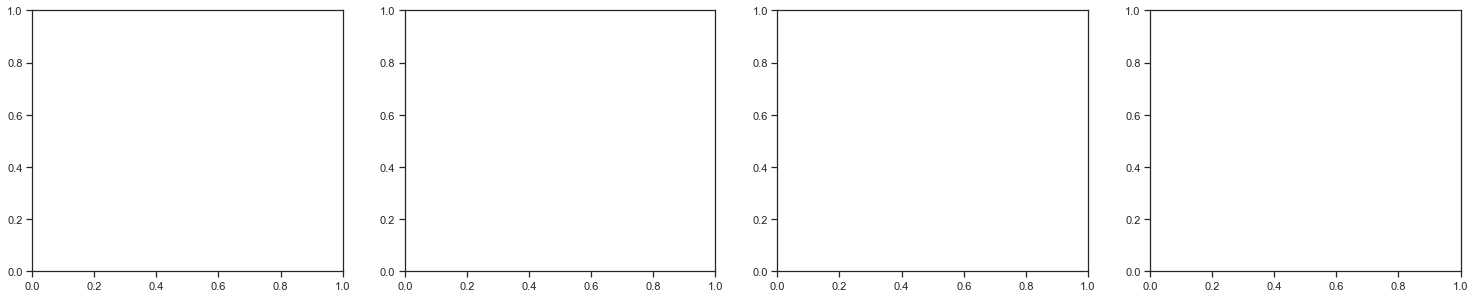

In [32]:
n=2
p=6
scatterdata= X_TSNEs[n][p]
hue_0 = count_sort_pseudo_label(HC_sublabels[n][0])
hue_0 = np.char.add('0-', hue_0.astype(str))
hue_1 = count_sort_pseudo_label(HC_sublabels[n][1])
hue_1 = np.char.add('1-', hue_1.astype(str))
hue_2 = count_sort_pseudo_label(HC_sublabels[n][2])
hue_2 = np.char.add('2-', hue_2.astype(str))
n_sub_groups_0 = len(np.unique(hue_0))
n_sub_groups_1 = len(np.unique(hue_1))
n_sub_groups_2 = len(np.unique(hue_2))

# X_merge_back = np.vstack([scatterdata[1], scatterdata[2], scatterdata[3]])
# y_merge_back = np.hstack([hue_0, hue_1, hue_2])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25.6,4.8))

sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=y, palette=cmap_point[:3], ax=ax1)


sns.scatterplot(x=scatterdata[1][:,0], y=scatterdata[1][:,1], hue=hue_0,
                palette=cmap_sbb_0(n_sub_groups_0), ax=ax2)

sns.scatterplot(x=scatterdata[2][:,0], y=scatterdata[2][:,1], hue=hue_1,
                palette=cmap_sbb_1(n_sub_groups_1), ax=ax3)

sns.scatterplot(x=scatterdata[3][:,0], y=scatterdata[3][:,1], hue=hue_2,
                palette=cmap_sbb_2(n_sub_groups_2), ax=ax4)
ax3.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax3.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax4.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
f.suptitle(f'start with n_PCs={n_comps[n]}, perplexity={perplexities[p]}, sub0={4}, sub1={7}, sub2={6}')
f.savefig('p2-part1-1.png') 
plt.show()

In [33]:
cmap_all_sub = cmap_sbb_0(4) +cmap_sbb_1(5) +cmap_sbb_2(5)
len(cmap_all_sub)

14

In [34]:
np.unique(HC.labels_)

array([0, 1, 2])

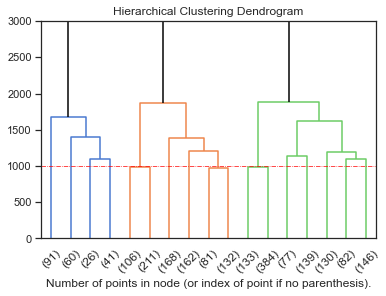

In [35]:
dis=1000


HC = AgglomerativeClustering(n_clusters=None, distance_threshold=dis, linkage='ward', 
                                 compute_distances=True, compute_full_tree=True).fit(X_pca_30_35[2])
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
d = plot_dendrogram(HC, truncate_mode='lastp', p=17 ,leaf_rotation=45, count_sort=True,
                color_threshold=3000, above_threshold_color='black', cmap=cmap_point[:3])
plt.axhline(y=1000, color='red', linestyle='-.', linewidth=0.7)
plt.ylim(top=3000)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('p2-part2-1_3.png')
plt.show()

In [36]:
HC.labels_[y==0]
HC.labels_[y==1]
HC.labels_[y==2]

array([ 0,  0,  0, ..., 11, 11, 11])

In [37]:
clf = SVC(random_state=0, C=0.9, break_ties=True, probability=True)
cv_results = cross_validate(clf, X_TSNEs[n][p][0], y, return_estimator=True)
print('cv test score = ', cv_results['test_score'])

clf_3class_tsne = cv_results['estimator'][np.argmax(cv_results['test_score'])]

TypeError: 'float' object is not subscriptable

In [226]:
n=2
p=6
scatterdata= X_TSNEs[n][p]
hue = HC.labels_.copy()
map_dict = {10:0, 13:1, 7:2, 5:3, 2:4, 4:5, 0:6, 3:7, 1:8, 9:9, 6:10, 12:11, 8:12, 11:13}
hue = np.vectorize(map_dict.__getitem__)(hue)

cmap_all_sub = cmap_sbb_0(4) +cmap_sbb_1(4) +cmap_sbb_2(6)


hue_0 = hue[y==0]
hue_0 = np.char.add('0-', hue_0.astype(str))
hue_1 = hue[y==1]
hue_1 = np.char.add('1-', hue_1.astype(str))
hue_2 = hue[y==2]
hue_2 = np.char.add('2-', hue_2.astype(str))
n_sub_groups_0 = len(np.unique(hue_0))
n_sub_groups_1 = len(np.unique(hue_1))
n_sub_groups_2 = len(np.unique(hue_2))

TypeError: 'float' object is not subscriptable

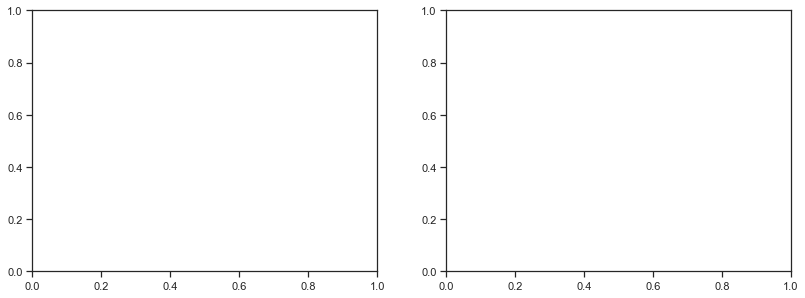

In [227]:
# total 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8*2,4.8))
x1x1_tsne, x2x2_tsne = make_meshgrid(scatterdata[0][:,0], scatterdata[0][:,1])

# origin 
ax1.set_title('(a) tSNE with par1-1 main-groups label')
plot_contours(ax1, clf_3class_tsne, x1x1_tsne, x2x2_tsne, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=y, palette=cmap_point[:3], ax=ax1)

# HC subtitle
ax2.set_title('(b) tSNE with sub-groups label')
plot_contours(ax2, clf_3class_tsne, x1x1_tsne, x2x2_tsne, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=hue, palette=cmap_all_sub, ax=ax2)
ax2.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
f.suptitle(f'{n_comps[n]} PCs, perplexity={perplexities[p]}, sub_0={4}, sub_1={4}, sub_2={6}')
f.savefig('p2-part1-2_1.png')
plt.show()

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6.8*3,4.8))
# main group 0
ax1.set_title('(a) tSNE with sub-groups label under main-group 0')
sns.scatterplot(x=scatterdata[1][:,0], y=scatterdata[1][:,1], hue=hue_0,
                palette=cmap_sbb_0(n_sub_groups_0), ax=ax1)
# ax1.set_facecolor(cmap_DB[0])
# main group 1
ax2.set_title('(b) tSNE with sub-groups label under main-group 1')
sns.scatterplot(x=scatterdata[2][:,1], y=scatterdata[2][:,0], hue=hue_1,
                palette=cmap_sbb_1(n_sub_groups_1), ax=ax2)
# ax2.set_facecolor(cmap_DB[1])
# ax2.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

# main group 2
ax3.set_title('(c) tSNE with sub-groups label under main-group 2')
sns.scatterplot(x=scatterdata[3][:,0], y=scatterdata[3][:,1], hue=hue_2,
                palette=cmap_sbb_2(n_sub_groups_2), ax=ax3)
# ax3.set_facecolor(cmap_DB[2])

ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax3.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

f.suptitle(f'Zoom in each main-group')
f.savefig('p2-part1-2_2.png')
plt.show()

#### Selecting the number of clusters with silhouette analysis on KMeans clustering

In [299]:
# range_n_clusters = range(2,5)
# rs_sub_k = randomseeds[0]
# main_cmap = cmap_point


# find_r_different_n_cluster = len(range_n_clusters)
# number_of_main_group = len(np.unique(y))
# results_size = (find_r_different_n_cluster,  number_of_main_group)


# sub_labels=np.zeros(results_size).tolist()
# silhouette_avg = np.zeros(results_size).tolist()
# sample_silhouette_values = np.zeros(results_size).tolist()

# sub_cmap = np.zeros(results_size).tolist()


# # main group 0,1,2 PC
# mg_0_X = X_pca_60p[y==0,:]
# mg_1_X = X_pca_60p[y==1,:]
# mg_2_X = X_pca_60p[y==2,:]

# # main group 0,1,2 TSNE
# sctter_data = [X_TSNEs[4][1], X_TSNEs[4][2], X_TSNEs[4][3]]

In [ ]:
# for r in range(len(range_n_clusters)):
    
#     # Initialize the clusterer with n_clusters value and a random generator
# #     n_clusters = 4 + range_n_clusters[r]
# #     sub_group = KMeans(n_clusters=n_clusters, random_state=rs_sub_k)
#     # Create a subplot 
#     fig, ax = plt.subplots(number_of_main_group+1, 2, figsize=(4.8*4/3*2,4.8*4))

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 but in this example all
#     # lie within [-0.1, 1]
#   # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     for mg in np.unique(y):
#         # slide dataset by main group
#         mg_X = X_pca_35p[y==mg,:]
# #         mg_X = X_pca_60p[y==mg,:]
# #         sub_labels[r][mg] = sub_group.fit_predict(mg_X)
#         if mg == 0 :
#             n_clusters = r+4
#             sub_labels[r][mg] = kmean_sublabels[mg][r+3]
#         else:
#             n_clusters = 4 + range_n_clusters[r]
#             sub_labels[r][mg] = kmean_sublabels[mg][n_clusters-1]
            
#         # The silhouette_score gives the average value for all the samples.
#         # This gives a perspective into the density and separation of the formed clusters
#         silhouette_avg[r][mg] = silhouette_score(mg_X, sub_labels[r][mg])
#         print(f'For main group {mg} sub_groups = {n_clusters}, The average silhouette_score is :{silhouette_avg}')
#         # Compute the silhouette scores for each sample
#         sample_silhouette_values[r][mg] = silhouette_samples(mg_X, sub_labels[r][mg])
#         # sub group cmap
#         sub_cmap[r][mg] = sns.color_palette(f'blend:{cmap_point[mg]},{cmap_DB[mg]}', n_colors=n_clusters)
#         y_lower = 10
#         ax[mg,0].set_xlim([-0.1, 1])
#         ax[mg,0].set_ylim([0, len(mg_X) + (n_clusters + 1) * 10])
#         for i in range(n_clusters):
#             # Aggregate the silhouette scores for samples belonging to
#             # cluster i, and sort them
#             ith_cluster_silhouette_values = sample_silhouette_values[r][mg][sub_labels[r][mg] == i]

#             ith_cluster_silhouette_values.sort()

#             size_cluster_i = ith_cluster_silhouette_values.shape[0]
#             y_upper = y_lower + size_cluster_i

#             color = sub_cmap[r][mg][i]
#             ax[mg,0].fill_betweenx(np.arange(y_lower, y_upper),
#                               0, ith_cluster_silhouette_values,
#                               facecolor=color, edgecolor=color, alpha=0.7)

#             # Label the silhouette plots with their cluster numbers at the middle
#             ax[mg,0].text(-0.05, y_lower + 0.5 * size_cluster_i, f'{mg}-{i}')

#             # Compute the new y_lower for next plot
#             y_lower = y_upper + 10  # 10 for the 0 samples
#         ax[mg,0].set_title("The silhouette plot for the various clusters.")
#         ax[mg,0].set_xlabel("The silhouette coefficient values")
#         ax[mg,0].set_ylabel("Cluster label")
        

#         # The vertical line for average silhouette score of all the values
#         ax[mg,0].axvline(x=silhouette_avg[r][mg], color="red", linestyle="--")

#         ax[mg,0].set_yticks([])  # Clear the yaxis labels / ticks
#         ax[mg,0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        
#         # 2nd Plot showing the actual clusters formed
#         colors = sub_cmap[r][mg]
#         sns.scatterplot(x=sctter_data[mg][:,0], y=sctter_data[mg][:,1], hue=sub_labels[r][mg], palette=colors, ax=ax[mg,1])
# #         ax[mg,1].scatter(sctter_data[mg][:, 0], sctter_data[0][:, 1], marker='.', s=30, lw=0, alpha=0.7,
# #                 c=colors, edgecolor='k')

# #         # Labeling the clusters
# #         centers = sub_group.cluster_centers_
# #         # Draw white circles at cluster centers
# #         ax[mg,1].scatter(centers[:, 0], centers[:, 1], marker='o',
# #                          c="white", alpha=1, s=200, edgecolor='k')

# #         for i, c in enumerate(centers):
# #             ax[mg,1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
# #                               s=50, edgecolor='k')

#         ax[mg,1].set_title("The visualization of the clustered data.")
#         ax[mg,1].set_xlabel("Feature space for the 1st feature")
#         ax[mg,1].set_ylabel("Feature space for the 2nd feature")
    
#     sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=main_cmap[:number_of_main_group], ax=ax[-1,1])
#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

#     plt.show()

### Part 2 
#### 2
We will now treat your cluster assignments as labels for supervised learning. Fit a logistic regression model to the original data (not principal components), with your clustering as the target labels. Since the data is high-dimensional, make sure to regularize your model using your choice of ℓ1, ℓ2, or elastic net, and separate the data into training and validation or use cross-validation to select your model. Report your choice of regularization parameter and validation performance.

In [39]:
X_logistic = X.copy()
Y_logistic_psd =  HC.labels_.copy()
map_dict = {10:0, 13:1, 7:2, 5:3, 2:4, 4:5, 0:6, 3:7, 1:8, 9:9, 6:10, 12:11, 8:12, 11:13}
Y_logistic_psd = np.vectorize(map_dict.__getitem__)(Y_logistic_psd)
X_logistic.shape, Y_logistic_psd.shape

((2169, 45768), (2169,))

In [40]:
np.unique(Y_logistic_psd)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

In [76]:
param_range = np.logspace(-8, -1, 6)
param_range

array([1.00000000e-08, 2.51188643e-07, 6.30957344e-06, 1.58489319e-04,
       3.98107171e-03, 1.00000000e-01])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

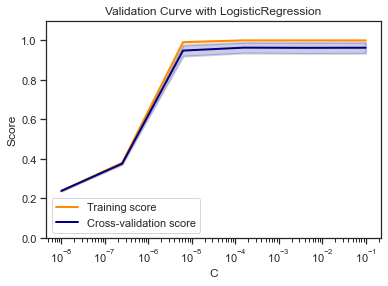

In [78]:
c_range = np.logspace(-8, -1, 6)

clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         verbose=1)

train_scores, test_scores = validation_curve(clf, X_logistic, Y_logistic_psd, param_name="C", param_range=c_range, cv=3,
                                             scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with LogisticRegression")
plt.xlabel(r"C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.legend(loc="best")
plt.savefig('p2-part2-2_l2.png')
plt.show()

In [54]:
# # mds boundaries 0.5 = 1, 
# # l2
# c_range = np.arange(0.001, 0.25, 0.08)
# for c in c_range:
#     clf = LogisticRegression(random_state=randomseeds[0],
#                              penalty='l2', solver='lbfgs', multi_class='multinomial',
#                              C=c, verbose=1)


#     cv_results = cross_validate(clf, X_logistic, Y_logistic_psd, return_estimator=True, cv=3)
#     print('cv test score = ', cv_results['test_score'])
#     print('avg cv test score = ', np.mean(cv_results['test_score']))

#     clf_logistic = cv_results['estimator'][np.argmax(cv_results['test_score'])]
#     print('train acc =\n', clf_logistic.score(X_logistic, Y_logistic_psd))
#     print('---')
# # np.where(clf_3class_mds.predict(X_mds)!=y), clf_3class_mds.get_params()

In [79]:
# mds boundaries 0.5 = 1, 
# l2

clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         C=c_range[2], verbose=1)


cv_results = cross_validate(clf, X_logistic, Y_logistic_psd, return_estimator=True, cv=5)
print('cv test score = ', cv_results['test_score'])
print('avg cv test score = ', np.mean(cv_results['test_score']))

clf_logistic = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_logistic.score(X_logistic, Y_logistic_psd))
print('---')
# np.where(clf_3class_mds.predict(X_mds)!=y), clf_3class_mds.get_params()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cv test score =  [0.95391705 0.96774194 1.         0.98156682 0.92147806]
avg cv test score =  0.9649407732995605
train acc =
 0.9944674965421854
---


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s finished


### 
(9 points) Select the features with the top 100 corresponding coefficient values (since this is a multi-class model, you can rank the coefficients using the maximum absolute value over classes, or the sum of absolute values). Take the evaluation training data and use a subset of the genes consisting of the features you selected. Train a logistic regression classifier on this training data, and evaluate its performance on the evaluation test data. Report your score.

Compare with two baselines: random features (take a random selection of 100 genes), and high-variance features (take the 100 genes with highest variance). Compare the variances of the features you selected with the highest variance features by plotting a histogram of the variances of features selected by both methods.

In [56]:
X_train = np.load('./data/p2_evaluation/X_train.npy')
Y_train = np.load('./data/p2_evaluation/Y_train.npy')
X_test  = np.load('./data/p2_evaluation/X_test.npy')
Y_test  = np.load('./data/p2_evaluation/Y_test.npy')

X_train = np.log2(X_train+1)
X_test = np.log2(X_test+1)

In [218]:
np.unique(Y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [81]:
top_100_coef_ind = np.argpartition(np.sum(np.abs(clf_logistic.coef_), axis=0), -100)[-100:]
top_100_coef_ind

array([ 3496, 38332,  5809, 38325, 34839, 24577, 23399, 36788,  8612,
        4383, 25332, 25499, 38605,  6864,  6040, 32109, 39723, 26116,
        5741, 40611, 38705, 45653, 38846,  5752, 38860, 40741,  4509,
       40520,  4441,  4832,   875,  4084,  7896,  8196, 45169,  6626,
       42749, 25530,  5838,  5523, 34559, 34572,  5849,  7473, 25473,
       31421,  5551, 44937, 42610, 38280, 38286,  5866, 25448, 25442,
        6648,  8586, 40160,  9356, 39439, 36780, 34844,  6756, 38551,
       34869, 34897, 34900,  8589, 40470, 34904, 36823, 35059, 24302,
       32327, 41860, 41846, 41782, 41728,  2770,  4688, 39736,  8001,
       41711, 24590, 40045, 40043,  4356, 41265, 39806, 37125, 38467,
        6042, 44094, 24483,  7555, 36986, 36985, 38398,  3903, 41385,
        2549])

In [82]:
np.var(X_train, axis=0).shape

(45768,)

In [83]:
top_100_var_ind = np.argpartition(np.var(X_train, axis=0), -100)[-100:]
top_100_var_ind

array([31616,  4855, 32140, 38779, 42363, 25475, 35059, 37956,  8511,
       41899, 40166,  6007,  2999,  8360,  3936, 34912,  5582, 41265,
       37076, 34528,  4407,  8254,  5838,  5752,  6040, 41711, 34301,
       25324,  6724, 45653,  6042,  8589, 40043, 24590, 25332, 34789,
        4356,  5815,  5809, 37125,  5741,  2549, 38398, 38467,  7896,
        7288, 38860,  4433, 41846,  7527, 34572, 39861, 34455, 45169,
        8586, 36985,  5551, 31421, 44094, 36986,  3320, 38846, 38286,
       25473,  5849, 24577, 24592,  6756,  7555, 34897, 34516, 25530,
        4441, 37024,  4688, 25442,  3043, 39451,  6864,  4832,   875,
       41782, 40160, 34527,  3840, 39439, 38280, 25693, 38606, 41385,
       34844, 34900,  9356,  3164,  7030, 40741, 34904, 24483, 40470,
        7473])

In [63]:
# random features
np.random.seed(randomseeds[0])
rand_features= np.random.randint(low=0, high=X_train.shape[1], size=100)

In [118]:
c_range

array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ])

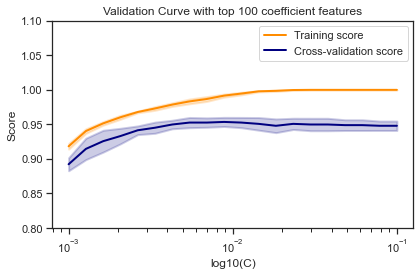

In [214]:
c_range = np.logspace(-3, -1, 20)

clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         verbose=0)

train_scores, test_scores = validation_curve(clf, X_train[:,top_100_coef_ind], Y_train,
                                             param_name="C", param_range=c_range, cv=5,
                                             scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with top 100 coefficient features")

lw = 2
plt.semilogx(c_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(c_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(c_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(c_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xlabel("log10(C)")
plt.ylabel("Score")
plt.ylim(0.8, 1.1)
plt.tight_layout()
plt.savefig('p2-part2-3_coef.png')
plt.show()

In [128]:
clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         C=0.01128838, verbose=0)


cv_results = cross_validate(clf, X_train[:,top_100_coef_ind], Y_train, return_estimator=True, cv=5)
print('cv test score = ', cv_results['test_score'])
print('avg cv test score = ', np.mean(cv_results['test_score']))

clf_logistic = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_logistic.score(X_train[:,top_100_coef_ind], Y_train))
print('test acc =\n', clf_logistic.score(X_test[:,top_100_coef_ind], Y_test))
print('---')

cv test score =  [0.95833333 0.94444444 0.95813953 0.95348837 0.94418605]
avg cv test score =  0.9517183462532299
train acc =
 0.9888579387186629
test acc =
 0.9296028880866426
---


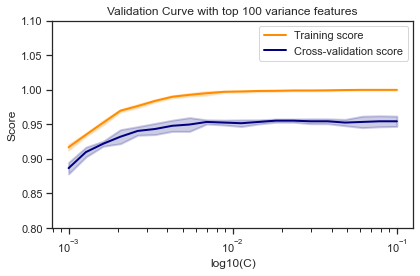

In [216]:
c_range = np.logspace(-3, -1, 20)

clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         verbose=0)

train_scores, test_scores = validation_curve(clf, X_train[:,top_100_var_ind], Y_train,
                                             param_name="C", param_range=c_range, cv=5,
                                             scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with top 100 variance features")
plt.xlabel("log10(C)")
plt.ylabel("Score")
plt.ylim(0.8, 1.1)
lw = 2
plt.semilogx(c_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(c_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(c_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(c_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('p2-part2-3_var.png')
plt.show()

In [126]:
clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         C=0.01128838)


cv_results = cross_validate(clf, X_train[:,top_100_var_ind], Y_train, return_estimator=True, cv=5)
print('cv test score = ', cv_results['test_score'])
print('avg cv test score = ', np.mean(cv_results['test_score']))

clf_logistic = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_logistic.score(X_train[:,top_100_var_ind], Y_train))
print('test acc =\n', clf_logistic.score(X_test[:,top_100_var_ind], Y_test))
print('---')

cv test score =  [0.9537037  0.95833333 0.95348837 0.94883721 0.94883721]
avg cv test score =  0.9526399655469424
train acc =
 0.9888579387186629
test acc =
 0.9386281588447654
---


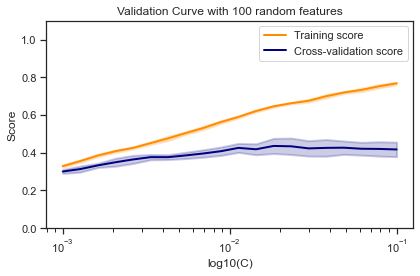

In [217]:
c_range = np.logspace(-3, -1, 20)

clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         verbose=0)

train_scores, test_scores = validation_curve(clf, X_train[:,rand_features], Y_train,
                                             param_name="C", param_range=c_range, cv=5,
                                             scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with 100 random features")
plt.xlabel("log10(C)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
lw = 2
plt.semilogx(c_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(c_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(c_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(c_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('p2-part2-3_random.png')
plt.show()

In [125]:
clf = LogisticRegression(random_state=randomseeds[0],
                         penalty='l2', solver='lbfgs', multi_class='multinomial',
                         C=0.1)


cv_results = cross_validate(clf, X_train[:,rand_features], Y_train, return_estimator=True, cv=5)
print('cv test score = ', cv_results['test_score'])
print('avg cv test score = ', np.mean(cv_results['test_score']))

clf_logistic = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_logistic.score(X_train[:,rand_features], Y_train))
print('test acc =\n', clf_logistic.score(X_test[:,rand_features], Y_test))
print('---')

cv test score =  [0.35648148 0.38888889 0.46046512 0.44651163 0.43255814]
avg cv test score =  0.4169810508182601
train acc =
 0.7075208913649025
test acc =
 0.3925992779783393
---


In [129]:
var_coef = np.var(X_train[:,top_100_coef_ind], axis=0)
hue1= 'coef'
var_var = np.var(X_train[:,top_100_var_ind], axis=0)
hue2='var'

In [170]:
df = pd.DataFrame(np.hstack([var_coef,var_var]))
df.columns = ['var']
df['hue'] = np.zeros(200)
df['hue'][:100] =  'coef'
df['hue'][100:] =  'var'

In [204]:
np.where(var_coef>18.3)[0].shape, np.where(var_var>18.3)[0].shape

((19,), (19,))

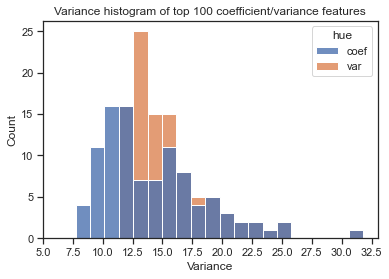

In [207]:
plt.title('Variance histogram of top 100 coefficient/variance features')
sns.histplot(data =df, x='var', hue='hue', bins=20, alpha=0.8)

plt.xlabel('Variance')
plt.xticks(np.arange(5,35,2.5))
plt.yticks(np.arange(0,30,5))
plt.savefig('p2-part2-3_hist.png')
plt.show()

In [ ]:
# total 

x1x1_tsne, x2x2_tsne = make_meshgrid(scatterdata[0][:,0], scatterdata[0][:,1])

# origin 
ax1.set_title('(a) tSNE with par1-1 main-groups label')
plot_contours(ax1, clf_3class_tsne, x1x1_tsne, x2x2_tsne, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=y, palette=cmap_point[:3], ax=ax1)

# HC subtitle
ax2.set_title('(b) tSNE with sub-groups label')
plot_contours(ax2, clf_3class_tsne, x1x1_tsne, x2x2_tsne, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=hue, palette=cmap_all_sub, ax=ax2)
ax2.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
f.suptitle(f'{n_comps[n]} PCs, perplexity={perplexities[p]}, sub_0={4}, sub_1={4}, sub_2={6}')
# f.savefig('p2-part1-2_1.png')
plt.show()

## Problem 3: Influence of Hyper-parameters

Include your answers to all parts of problem 3 in your written report. This problem is worth 16 points.

The hyper-parameter choices used in data analysis techniques can have a large impact on the inferences made. As you may have encountered, finding the best choice of parameter such as perplexity in T-SNE or the number of clusters can be an ambiguous problem. We will now investigate the sensitivity of your results to changes in these hyper-parameters, with the goal of understanding how your conclusions may vary depending on these choices.

### Problem 3.1
When we created the T-SNE plot in Problem 1, we ran T-SNE on the top 50 PC's of the data. But we could have easily chosen a different number of PC's to represent the data. Run T-SNE using 10, 50, 100, 250, and 500 PC's, and plot the resulting visualization for each. What do you observe as you increase the number of PC's used?



In [219]:
n_comps_3 = [10,50,100,250,500]

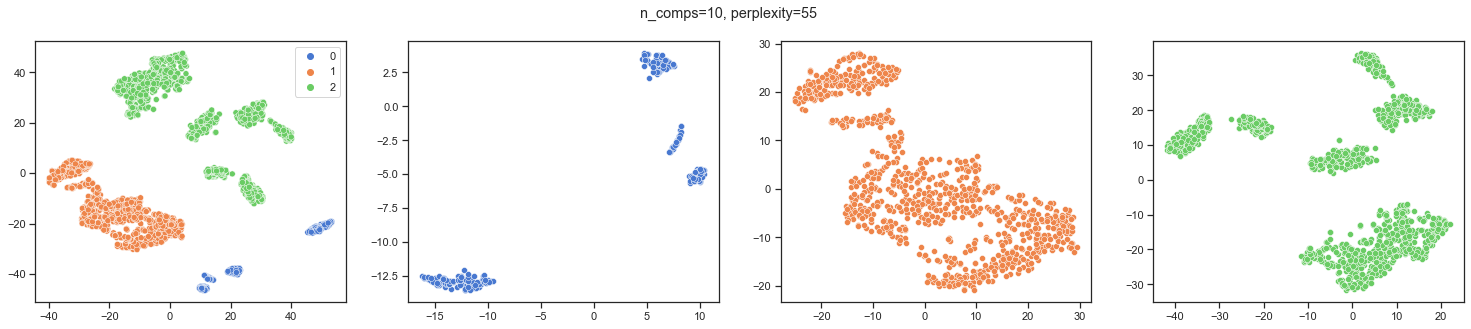

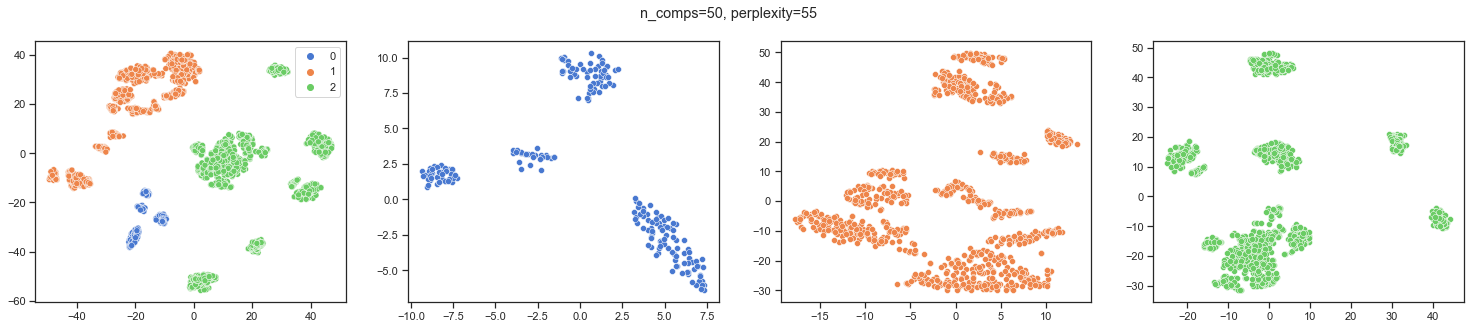

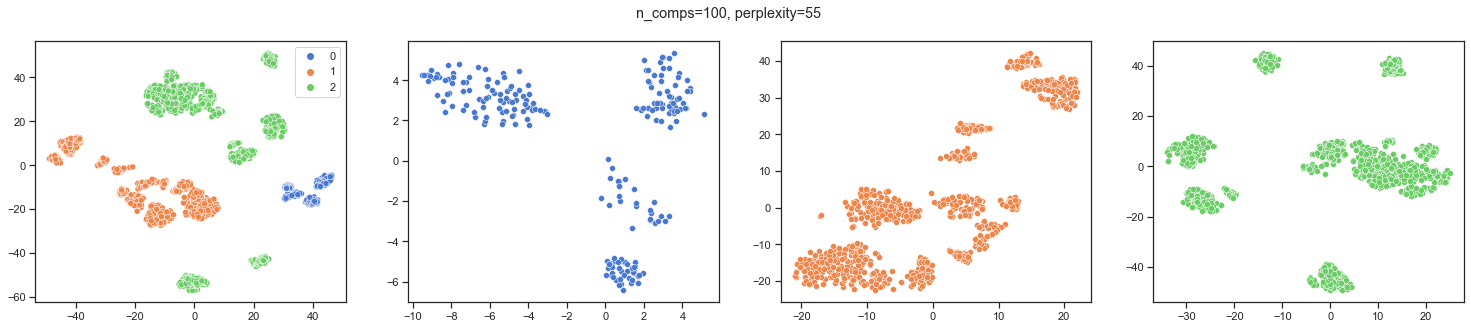

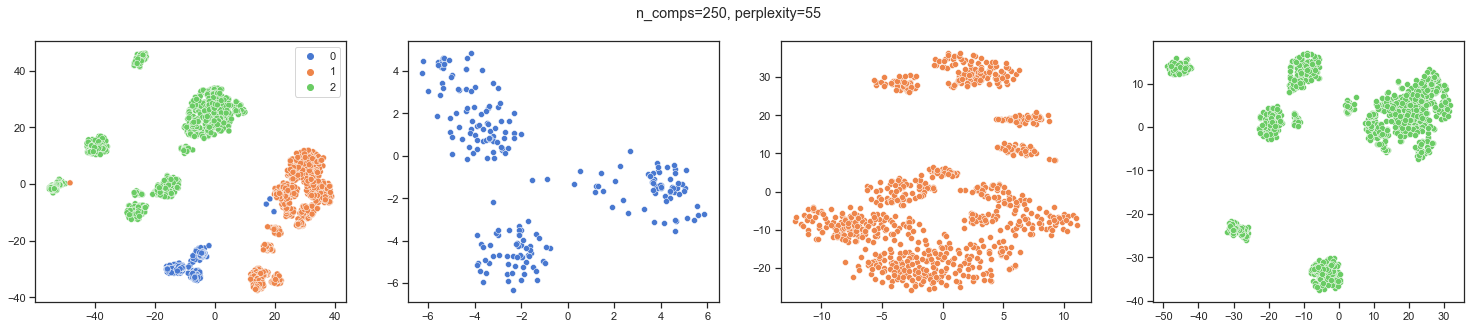

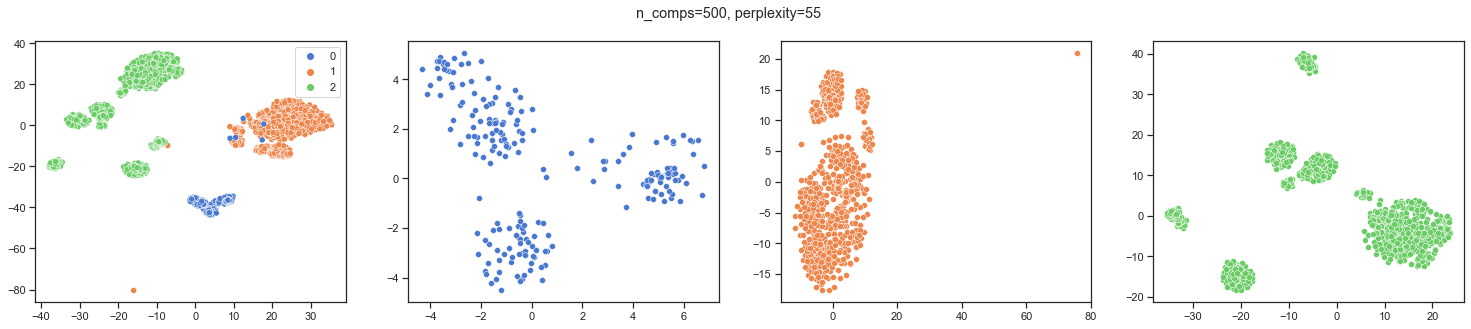

In [223]:
# 3.1 n-PCs
ppl = 55 
rs = randomseeds[4]
for i in range(len(n_comps_3)):
    pcahc = PCA(n_components = n_comps_3[i])
    X_pca = pcahc.fit_transform(X)

    tsne = TSNE(n_components=2, random_state=rs,
                perplexity=ppl)
    X_tsne = tsne.fit_transform(X_pca)
    X_tsne_0 = tsne.fit_transform(X_pca[y==0,:])
    X_tsne_1 = tsne.fit_transform(X_pca[y==1,:])
    X_tsne_2 = tsne.fit_transform(X_pca[y==2,:])

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25.6,4.8))

    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=cmap_point[:3], ax=ax1)
    sns.scatterplot(x=X_tsne_0[:,0], y=X_tsne_0[:,1], color=cmap_point[0], ax=ax2)
    sns.scatterplot(x=X_tsne_1[:,0], y=X_tsne_1[:,1], color=cmap_point[1], ax=ax3)
    sns.scatterplot(x=X_tsne_2[:,0], y=X_tsne_2[:,1], color=cmap_point[2], ax=ax4)

    f.suptitle(f' n_comps={n_comps_3[i]}, perplexity={ppl}')
    f.savefig(f'p3-1_{n_comps_3[i]}_tsne.png')
    plt.show()

### Problem 3.2


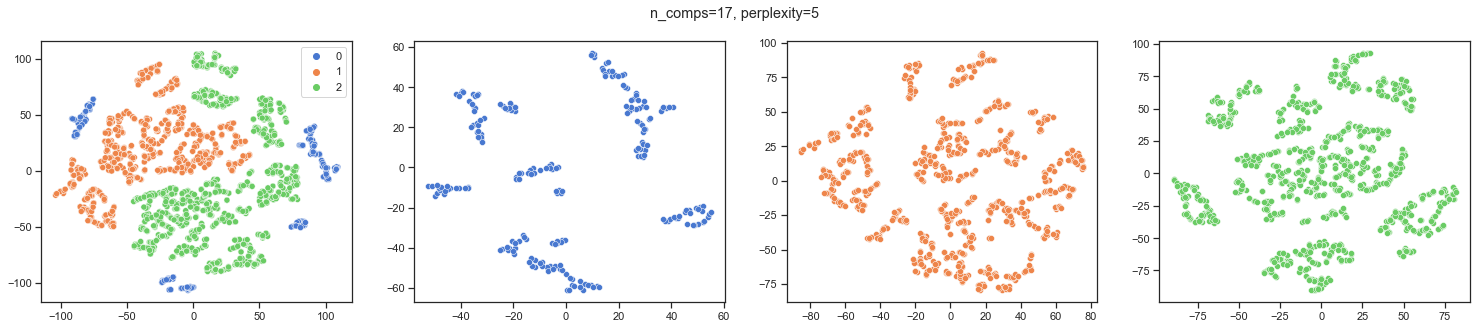

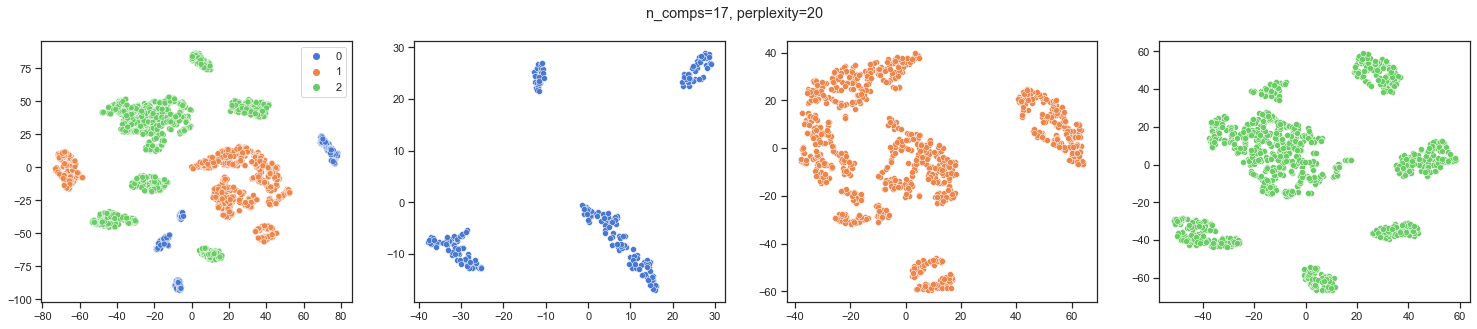

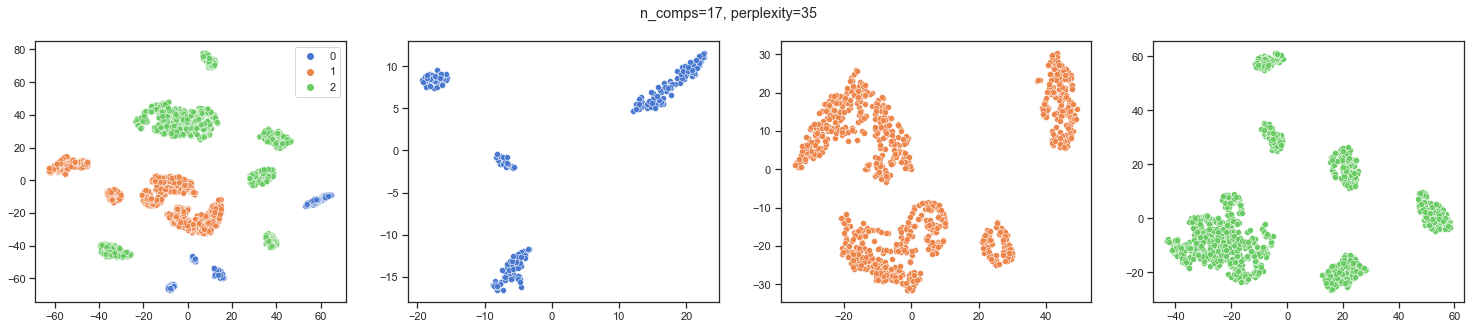

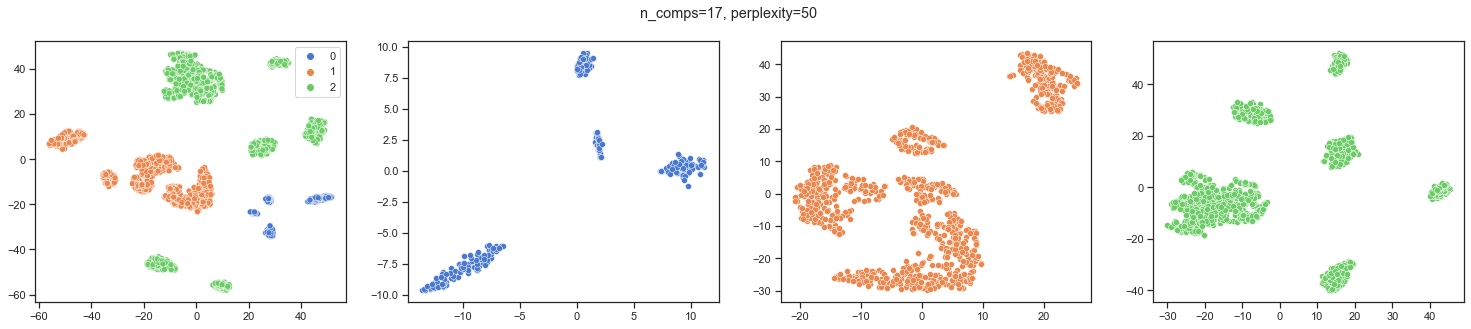

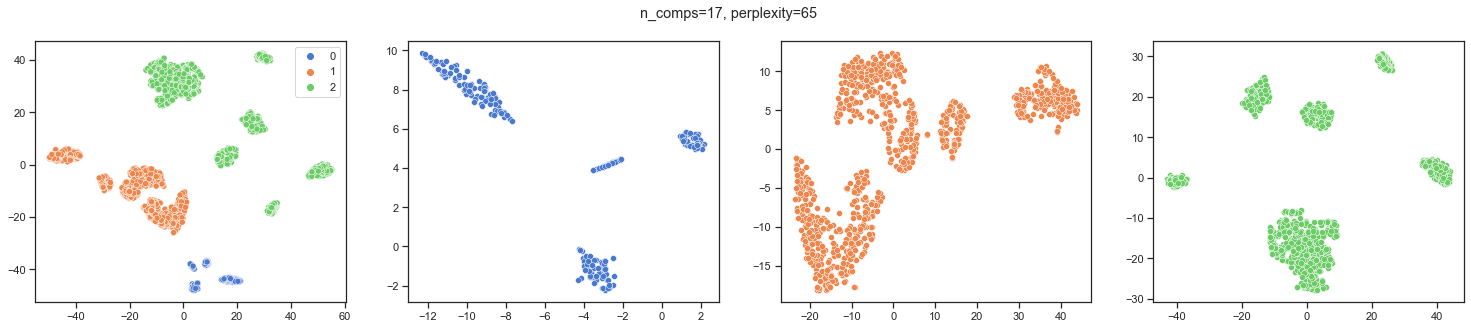

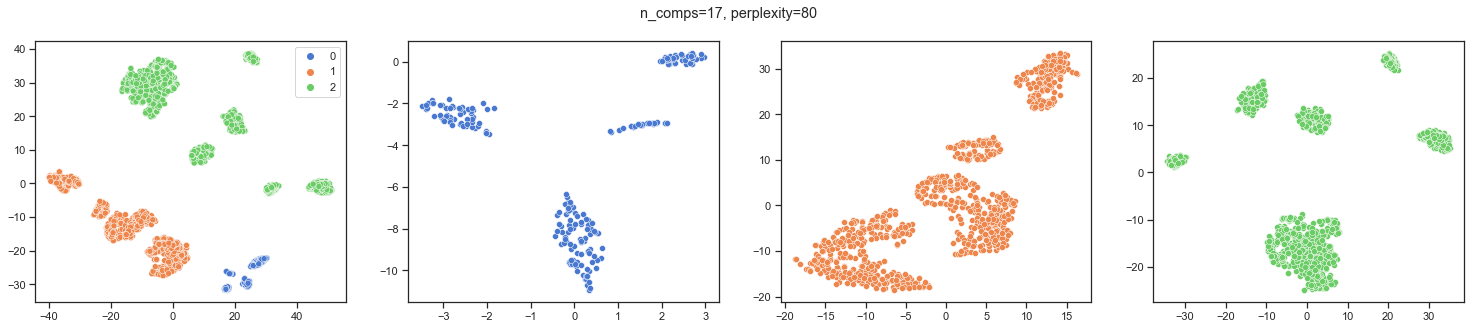

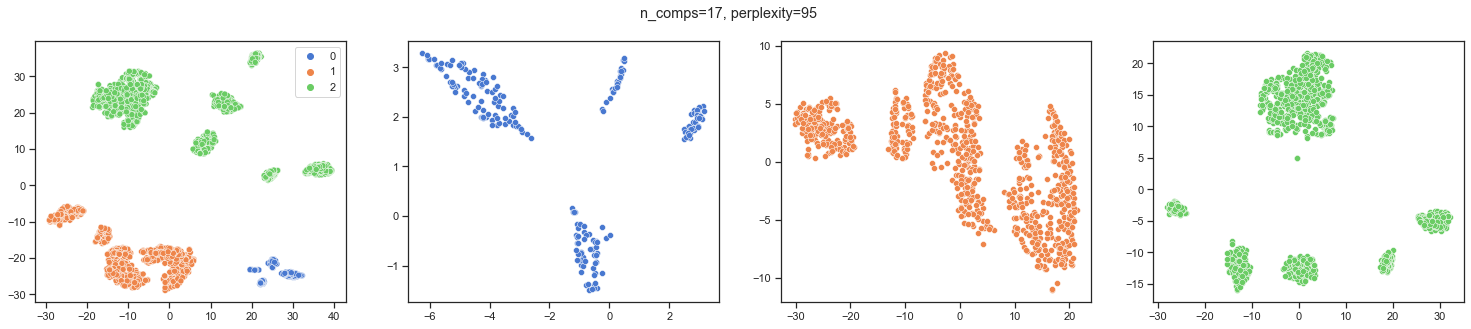

In [237]:
# p3-2, perplexity
X_pca = X_pca_30_35[0]
for ppl in np.arange(5,96,15):
    tsne = TSNE(n_components=2, perplexity=ppl, random_state=rs)
    X_tsne = tsne.fit_transform(X_pca)
    X_tsne_0 = tsne.fit_transform(X_pca[y==0,:])
    X_tsne_1 = tsne.fit_transform(X_pca[y==1,:])
    X_tsne_2 = tsne.fit_transform(X_pca[y==2,:])

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25.6,4.8))

    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=cmap_point[:3], ax=ax1)
    sns.scatterplot(x=X_tsne_0[:,0], y=X_tsne_0[:,1], color=cmap_point[0], ax=ax2)
    sns.scatterplot(x=X_tsne_1[:,0], y=X_tsne_1[:,1], color=cmap_point[1], ax=ax3)
    sns.scatterplot(x=X_tsne_2[:,0], y=X_tsne_2[:,1], color=cmap_point[2], ax=ax4)

    f.suptitle(f' n_comps={n_comps[0]}, perplexity={ppl}')
    f.savefig(f'p3-2_{ppl}_perplexity.png')
    plt.show()

In [229]:
X_pca = X_pca_30_35[2]

tsne = TSNE(n_components=2, random_state=randomseeds[0],
                perplexity=perplexities[p])
X_tsne = tsne.fit_transform(X_pca)
X_tsne_0 = tsne.fit_transform(X_pca[y==0])
X_tsne_1 = tsne.fit_transform(X_pca[y==1])
X_tsne_2 = tsne.fit_transform(X_pca[y==2])

scatterdata = [X_tsne, X_tsne_0, X_tsne_1, X_tsne_2]

14
14
1
3
1
3
1
3


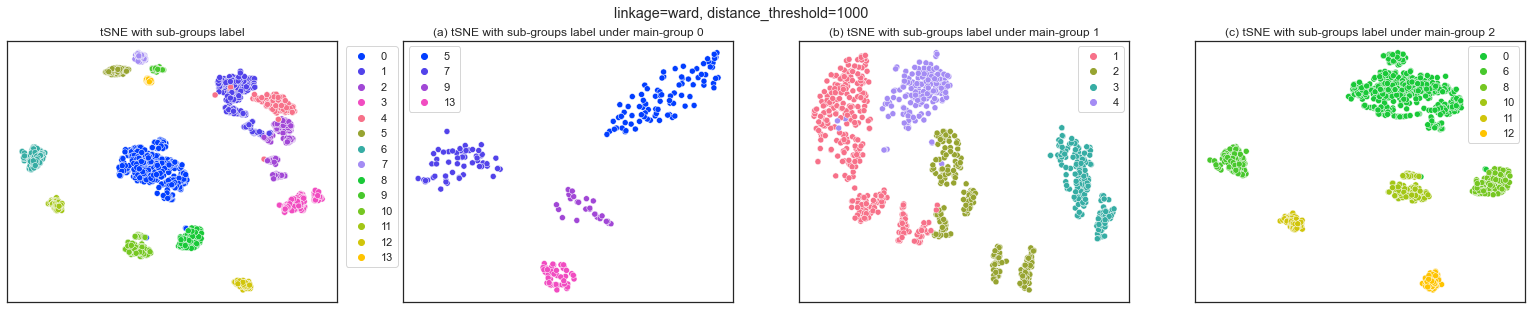

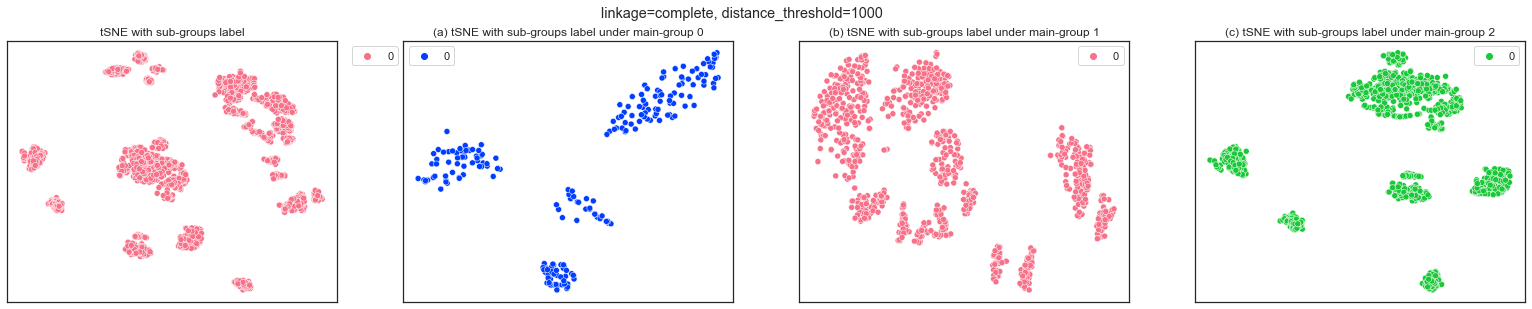

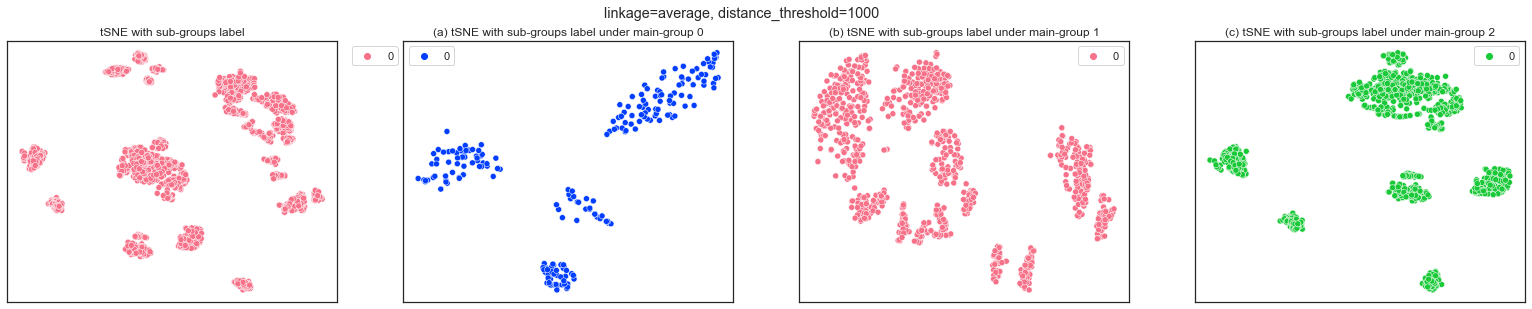

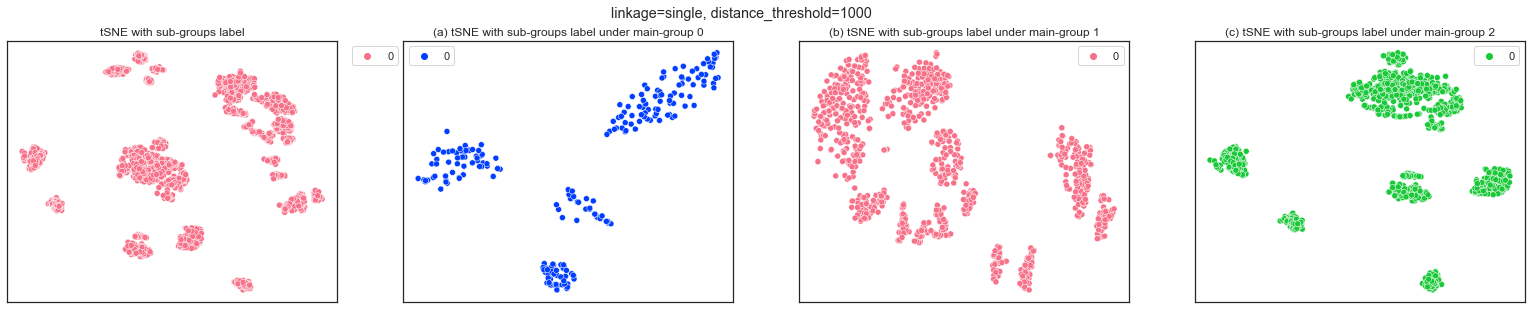

10
10
1
3
1
3
1
3


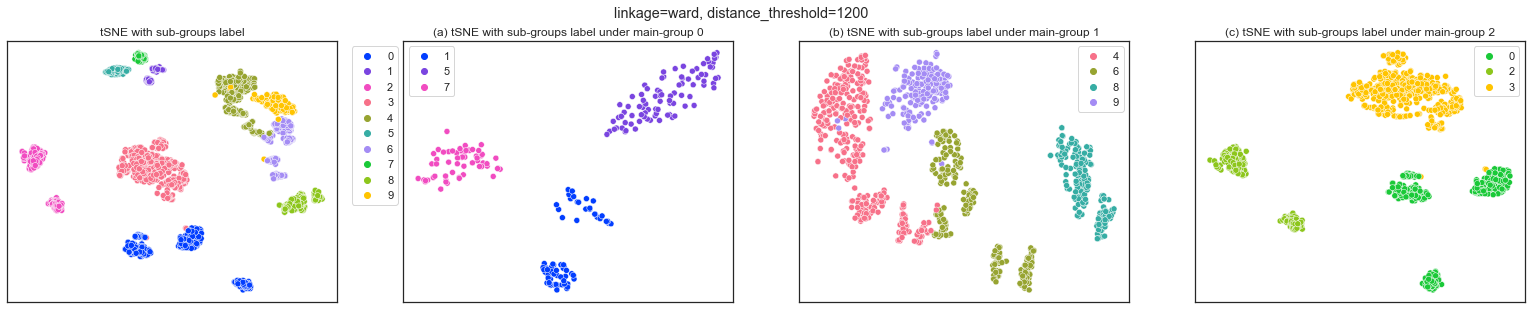

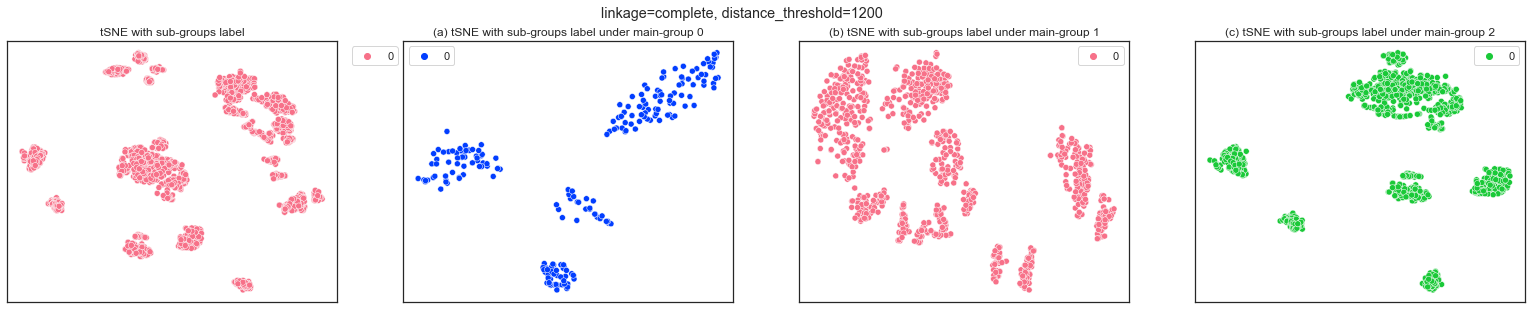

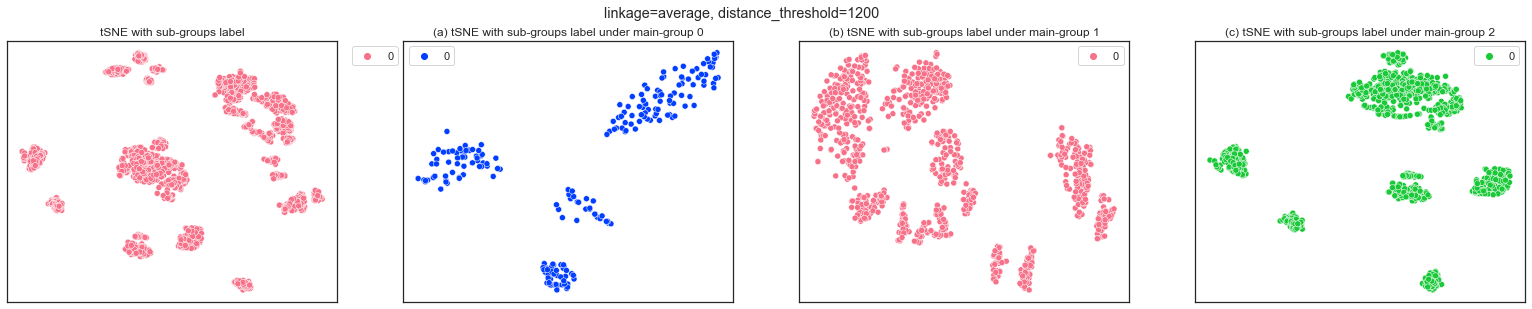

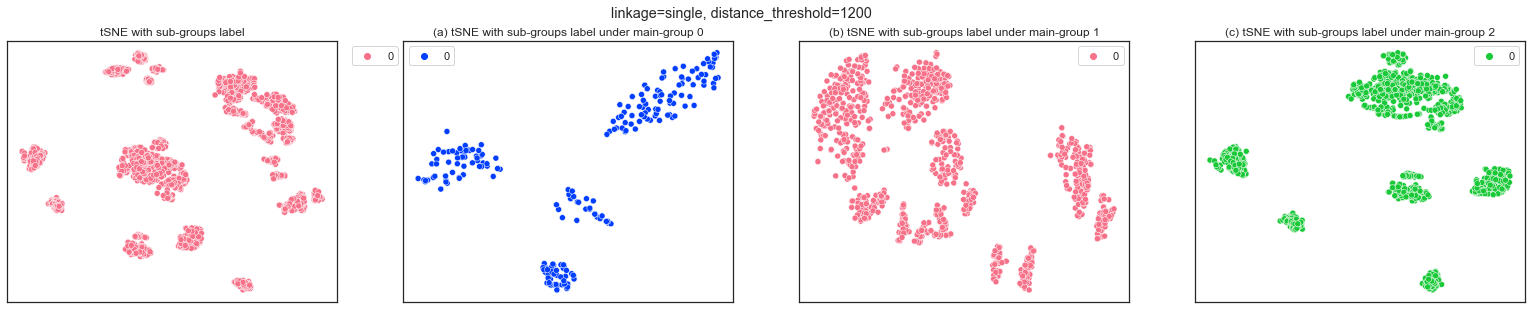

In [242]:
# p3-2, linkage
linkages = ['ward', 'complete', 'average','single']
for dis in np.arange(1000, 1400, 200):
    for link in linkages:
        HC = AgglomerativeClustering(n_clusters=None, distance_threshold=dis, linkage=link, 
                                     compute_distances=True, compute_full_tree=True).fit(X_pca_30_35[2])
        HC_labels = HC.labels_

        hue = HC_labels
        print(len(np.unique(hue)))
        hue_0 = hue[y==0]
        hue_1 = hue[y==1]
        hue_2 = hue[y==2]


        n_sub_groups_0 = len(np.unique(hue_0))
        n_sub_groups_1 = len(np.unique(hue_1))
        n_sub_groups_2 = len(np.unique(hue_2))
        print(n_sub_groups_0+n_sub_groups_1+n_sub_groups_2)

        if (n_sub_groups_0+n_sub_groups_1+n_sub_groups_2) > len(np.unique(hue)):
            cmap_all_sub = cmap_sbb_1(len(np.unique(hue)))
        else:
            cmap_all_sub = cmap_sbb_0(n_sub_groups_0) +cmap_sbb_1(n_sub_groups_1) +cmap_sbb_2(n_sub_groups_2)
        f, (ax4, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(6.8*4,4.8))

        ax4.set_title('tSNE with sub-groups label')
        sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=hue, palette=cmap_all_sub, ax=ax4)
        ax4.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

        ax4.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        # main group 0
        ax1.set_title('(a) tSNE with sub-groups label under main-group 0')
        sns.scatterplot(x=scatterdata[1][:,0], y=scatterdata[1][:,1], hue=hue_0,
                        palette=cmap_sbb_0(n_sub_groups_0), ax=ax1)
        # ax1.set_facecolor(cmap_DB[0])
        # main group 1
        ax2.set_title('(b) tSNE with sub-groups label under main-group 1')
        sns.scatterplot(x=scatterdata[2][:,1], y=scatterdata[2][:,0], hue=hue_1,
                        palette=cmap_sbb_1(n_sub_groups_1), ax=ax2)
        # ax2.set_facecolor(cmap_DB[1])
        # ax2.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

        # main group 2
        ax3.set_title('(c) tSNE with sub-groups label under main-group 2')
        sns.scatterplot(x=scatterdata[3][:,0], y=scatterdata[3][:,1], hue=hue_2,
                        palette=cmap_sbb_2(n_sub_groups_2), ax=ax3)
        # ax3.set_facecolor(cmap_DB[2])

        ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        ax3.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        f.suptitle(f'linkage={link}, distance_threshold={dis}')
        f.savefig(f'p3-2_{link}_1000_HClinkage.png')
    plt.show()

44
44
20
21
8
9


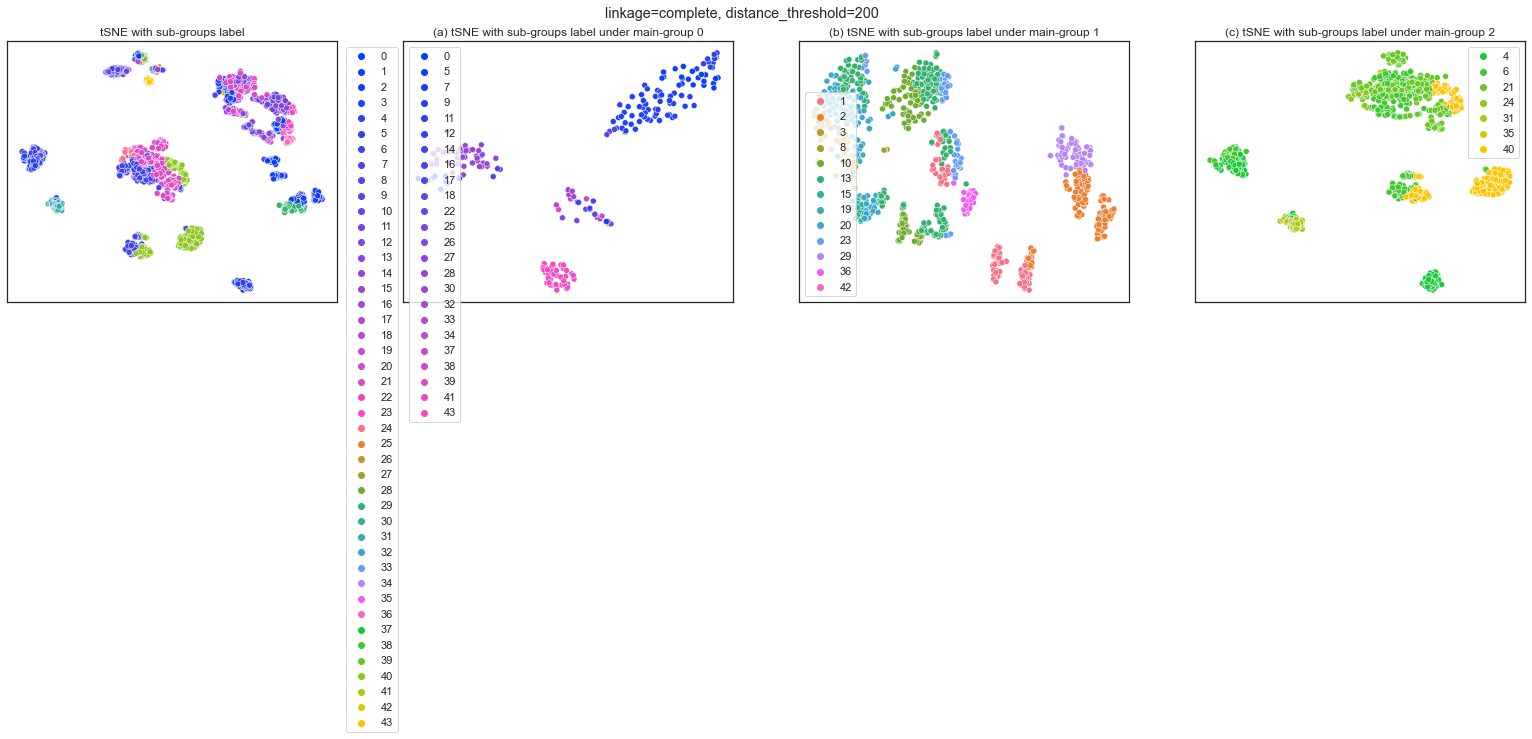

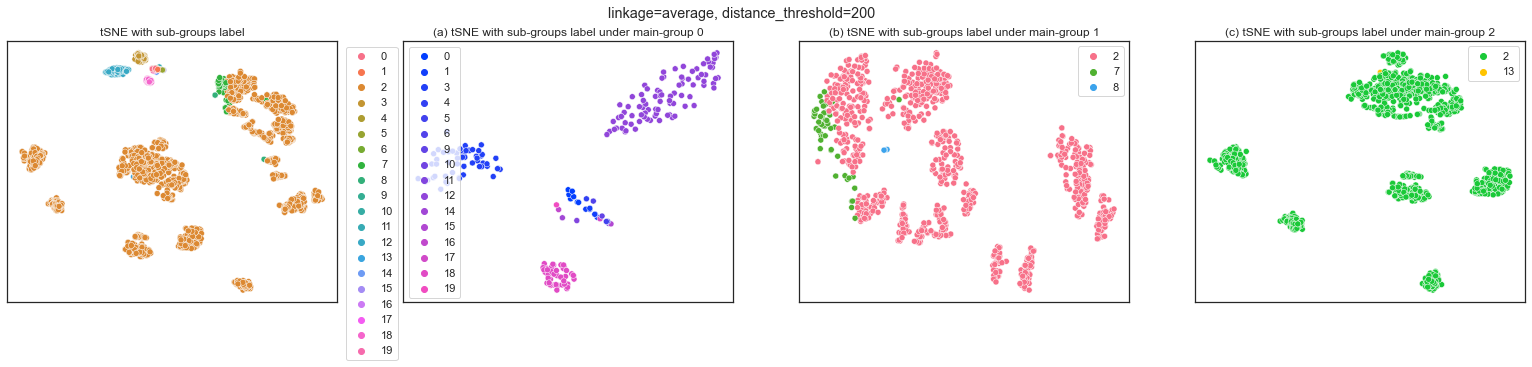

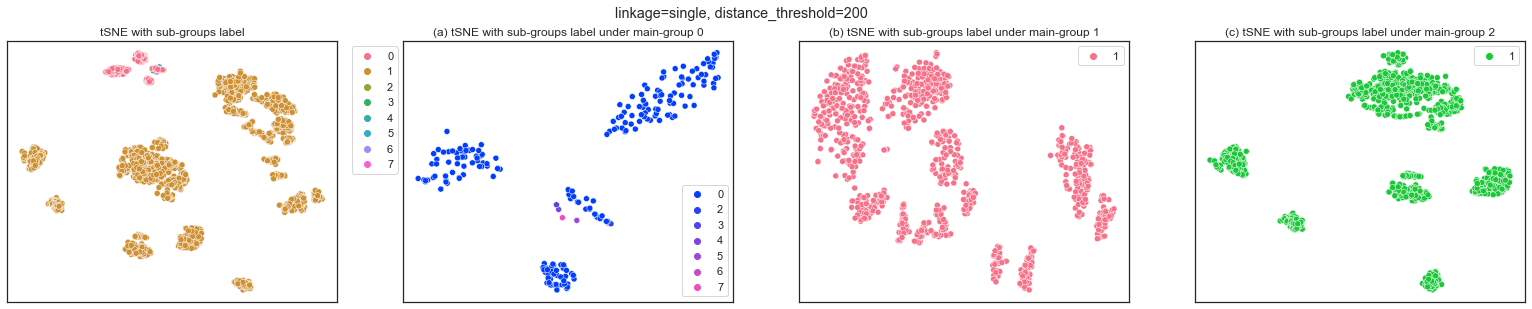

7
9
3
4
1
3


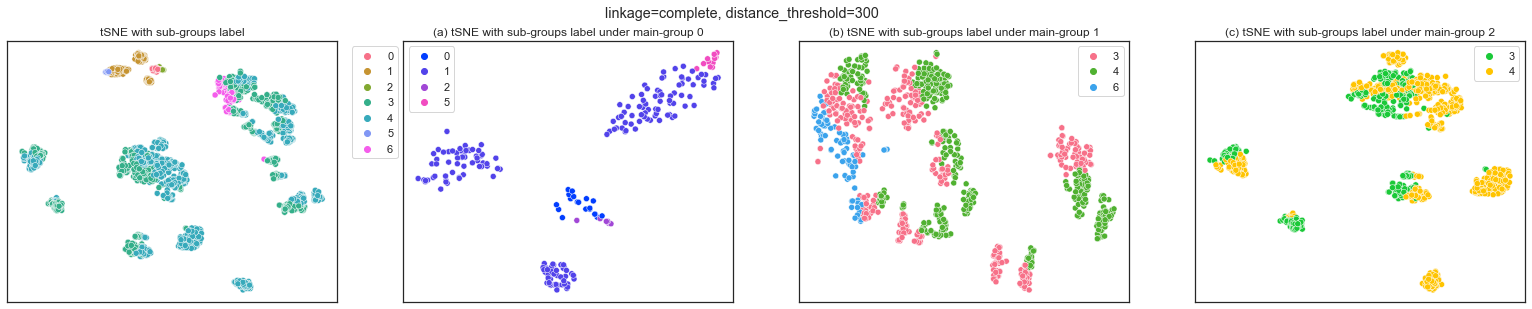

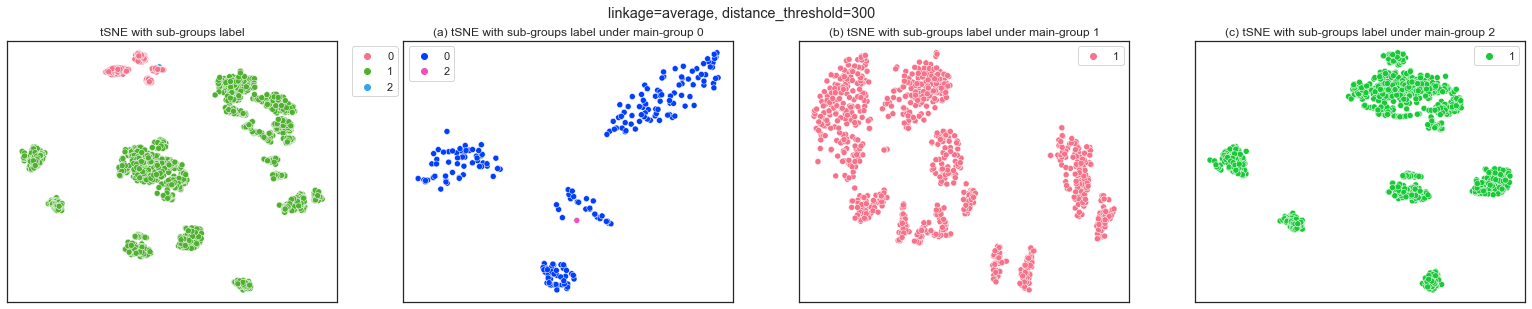

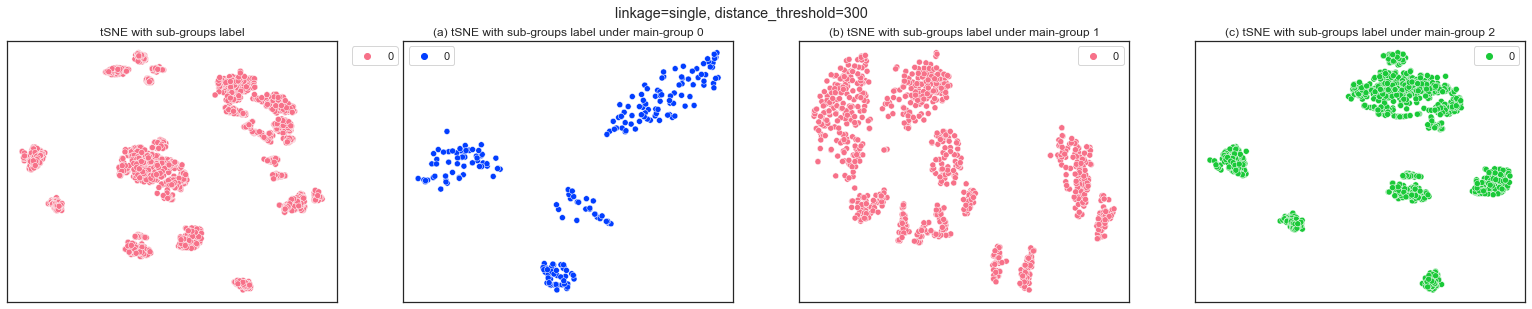

3
4
1
3
1
3


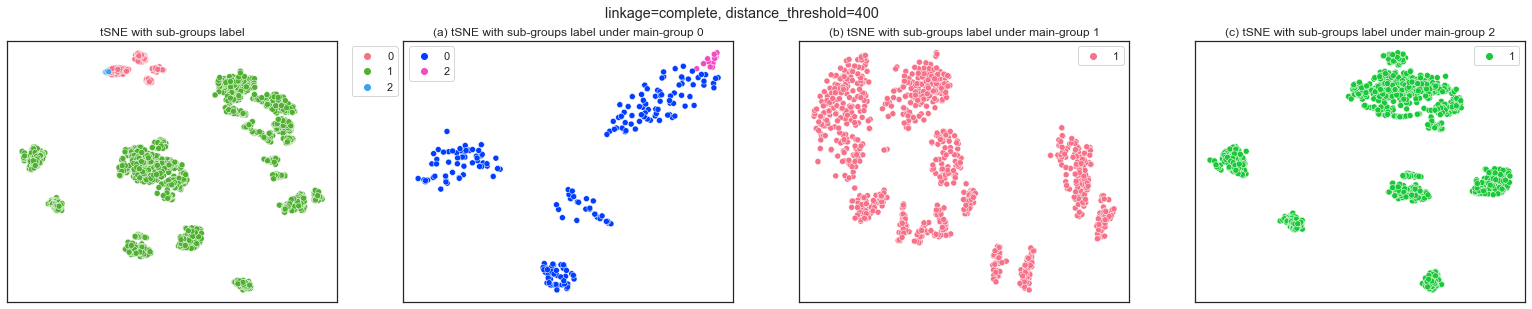

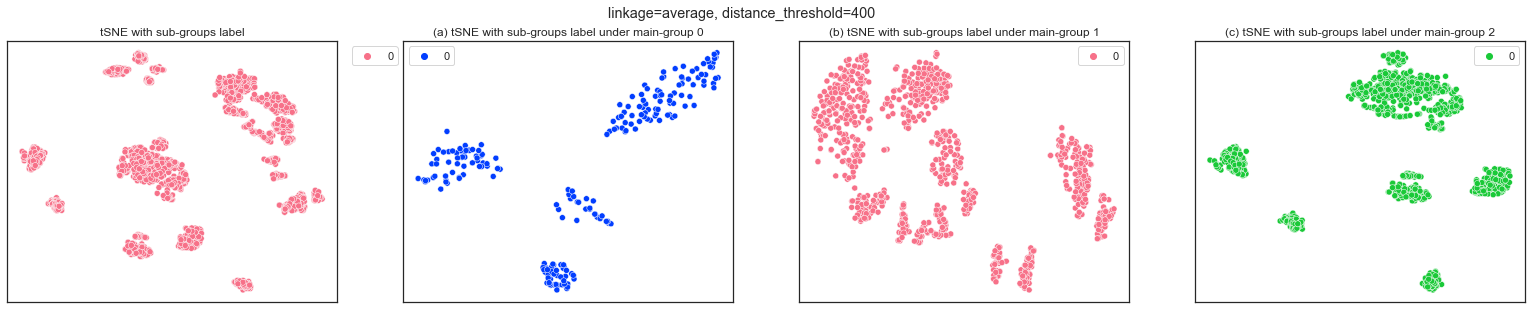

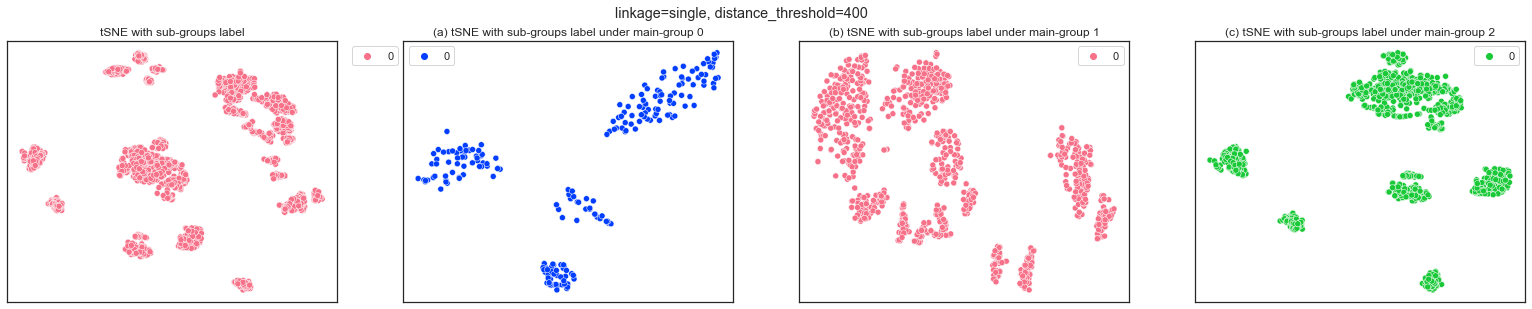

2
3
1
3
1
3


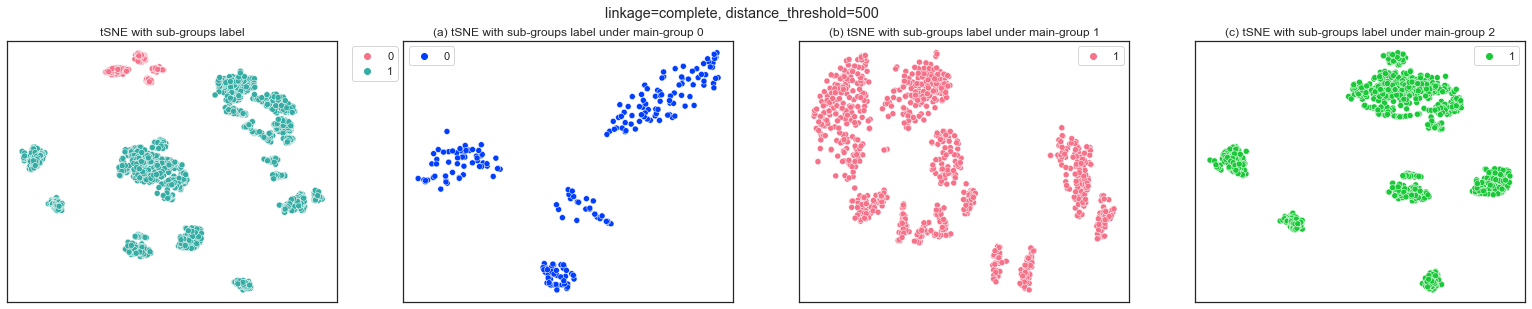

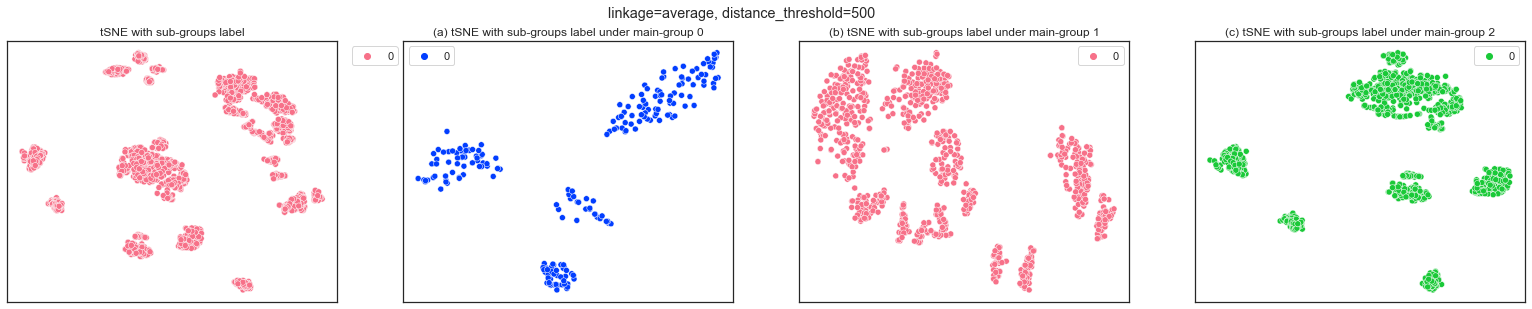

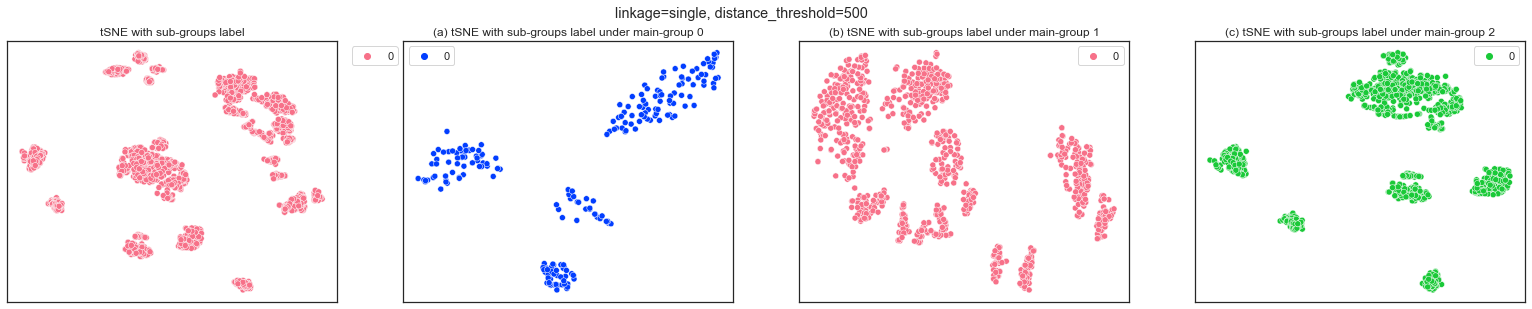

In [245]:
# p3-2, linkage
linkages = ['complete', 'average','single']
for dis in np.arange(200, 600, 100):
    for link in linkages:
        HC = AgglomerativeClustering(n_clusters=None, distance_threshold=dis, linkage=link, 
                                     compute_distances=True, compute_full_tree=True).fit(X_pca_30_35[2])
        HC_labels = HC.labels_

        hue = HC_labels
        print(len(np.unique(hue)))
        hue_0 = hue[y==0]
        hue_1 = hue[y==1]
        hue_2 = hue[y==2]


        n_sub_groups_0 = len(np.unique(hue_0))
        n_sub_groups_1 = len(np.unique(hue_1))
        n_sub_groups_2 = len(np.unique(hue_2))
        print(n_sub_groups_0+n_sub_groups_1+n_sub_groups_2)

        if (n_sub_groups_0+n_sub_groups_1+n_sub_groups_2) > len(np.unique(hue)):
            cmap_all_sub = cmap_sbb_1(len(np.unique(hue)))
        else:
            cmap_all_sub = cmap_sbb_0(n_sub_groups_0) +cmap_sbb_1(n_sub_groups_1) +cmap_sbb_2(n_sub_groups_2)
        f, (ax4, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(6.8*4,4.8))

        ax4.set_title('tSNE with sub-groups label')
        sns.scatterplot(x=scatterdata[0][:,0], y=scatterdata[0][:,1], hue=hue, palette=cmap_all_sub, ax=ax4)
        ax4.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

        ax4.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        # main group 0
        ax1.set_title('(a) tSNE with sub-groups label under main-group 0')
        sns.scatterplot(x=scatterdata[1][:,0], y=scatterdata[1][:,1], hue=hue_0,
                        palette=cmap_sbb_0(n_sub_groups_0), ax=ax1)
        # ax1.set_facecolor(cmap_DB[0])
        # main group 1
        ax2.set_title('(b) tSNE with sub-groups label under main-group 1')
        sns.scatterplot(x=scatterdata[2][:,1], y=scatterdata[2][:,0], hue=hue_1,
                        palette=cmap_sbb_1(n_sub_groups_1), ax=ax2)
        # ax2.set_facecolor(cmap_DB[1])
        # ax2.legend(loc='best', bbox_to_anchor=(0.7, 0.5, 0.5, 0.5))

        # main group 2
        ax3.set_title('(c) tSNE with sub-groups label under main-group 2')
        sns.scatterplot(x=scatterdata[3][:,0], y=scatterdata[3][:,1], hue=hue_2,
                        palette=cmap_sbb_2(n_sub_groups_2), ax=ax3)
        # ax3.set_facecolor(cmap_DB[2])

        ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        ax3.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

        f.suptitle(f'linkage={link}, distance_threshold={dis}')
        f.savefig(f'p3-2_{link}_1000_HClinkage.png')
    plt.show()

In [89]:
# p3-2, linkage

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]))

In [99]:
for uni in np.unique(y_train):
    print(uni)
    print( np.count_nonzero(y_train==uni))
    print('----')

0
17
----
1
19
----
2
71
----
3
19
----
4
17
----
5
12
----
6
14
----
7
37
----
8
53
----
9
20
----
10
28
----
11
15
----
12
44
----
13
14
----
14
25
----
15
22
----
16
27
----
17
168
----
18
31
----
19
17
----
20
53
----
21
12
----
22
13
----
23
56
----
24
18
----
25
10
----
26
30
----
27
69
----
28
15
----
29
11
----
30
12
----
31
13
----
32
20
----
33
20
----
34
10
----
35
45
----


#### Selecting the number of clusters with silhouette analysis on KMeans clustering

- [reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

In [35]:
for r in range(len(range_n_clusters)):
    
    # Initialize the clusterer with n_clusters value and a random generator
    n_clusters = range_n_clusters[r]
    sub_group = KMeans(n_clusters=n_clusters, random_state=rs_sub_k)
    # Create a subplot 
    fig, ax = plt.subplots(number_of_main_group+1, 2, figsize=(4.8*4/3*2,4.8*4))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    for mg in np.unique(y):
        # slide dataset by main group
        mg_X = X_pca_60p[y==mg,:]
        sub_labels[r][mg] = sub_group.fit_predict(mg_X)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg[r][mg] = silhouette_score(mg_X, sub_labels[r][mg])
        print(f'For main group {mg} sub_groups = {n_clusters}, The average silhouette_score is :{silhouette_avg}')
        # Compute the silhouette scores for each sample
        sample_silhouette_values[r][mg] = silhouette_samples(mg_X, sub_labels[r][mg])
        # sub group cmap
        sub_cmap[r][mg] = sns.color_palette(f'blend:{cmap_point[mg]},{cmap_DB[mg]}', n_colors=n_clusters)
        y_lower = 10
        ax[mg,0].set_xlim([-0.1, 1])
        ax[mg,0].set_ylim([0, len(mg_X) + (n_clusters + 1) * 10])
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[r][mg][sub_labels[r][mg] == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = sub_cmap[r][mg][i]
            ax[mg,0].fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax[mg,0].text(-0.05, y_lower + 0.5 * size_cluster_i, f'{mg}-{i}')

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        ax[mg,0].set_title("The silhouette plot for the various clusters.")
        ax[mg,0].set_xlabel("The silhouette coefficient values")
        ax[mg,0].set_ylabel("Cluster label")
        

        # The vertical line for average silhouette score of all the values
        ax[mg,0].axvline(x=silhouette_avg[r][mg], color="red", linestyle="--")

        ax[mg,0].set_yticks([])  # Clear the yaxis labels / ticks
        ax[mg,0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        
        # 2nd Plot showing the actual clusters formed
        colors = sub_cmap[r][mg]
        sns.scatterplot(x=sctter_data[mg][:,0], y=sctter_data[mg][:,1], hue=sub_labels[r][mg], palette=colors, ax=ax[mg,1])
#         ax[mg,1].scatter(sctter_data[mg][:, 0], sctter_data[0][:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#         # Labeling the clusters
#         centers = sub_group.cluster_centers_
#         # Draw white circles at cluster centers
#         ax[mg,1].scatter(centers[:, 0], centers[:, 1], marker='o',
#                          c="white", alpha=1, s=200, edgecolor='k')

#         for i, c in enumerate(centers):
#             ax[mg,1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                               s=50, edgecolor='k')

        ax[mg,1].set_title("The visualization of the clustered data.")
        ax[mg,1].set_xlabel("Feature space for the 1st feature")
        ax[mg,1].set_ylabel("Feature space for the 2nd feature")
    
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=main_cmap[:number_of_main_group], ax=ax[-1,1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()